In [1]:
import wikipedia
import pandas as pd
import numpy as np
import re, os, requests
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

import gensim
from nltk import word_tokenize, pos_tag, FreqDist
from nltk.corpus import stopwords, words
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline

/Users/piocalderon/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**Note 1:** Start from Part 3 if you you want to skip data scraping and cleaning

**Note 2:** Parts 1 and 2 are the same from the first notebook. I added Part 2.5 for Wiki scraping

# Part 1: Web Scraping
**Task**: Scrape movie box office performance and metadata from boxofficemojo.com

**Timeframe Considered**: 2010-2018 (5645 movies)

In [5]:
def get_film_metadata(url_string):
    """
        Obtain movie metadata from the url of a movie's page
        
        Input:
            url_string : movie metadata url
        Output:
            movie_dict : dictionary of movie information
    """
    
    url = requests.get(url_string)
    bs = BeautifulSoup(url.content, 'lxml')  
    
    # select table of metadata information 
    entries = bs.select('center td')
    
    # table entries are in the form 'label: xxx'
    # retain only xxx
    remove_label = lambda x: x[x.find(':') + 2:]
    
    # get list of metadata values
    fixed_entries = [remove_label(entry.text) for entry in entries]
    # get list of metadata labels
    meta_labels = ['total_gross', 'distributor', 'release_date', 'genre', 'runtime', 'rating', 'budget']
                       
    # combine values and labels to a dict
    metadata_dict = dict(zip(meta_labels, fixed_entries))
                       
    return metadata_dict

In [6]:
def process_row(row, base):
    """
        Process a single row in the movie performance table
        
        Input:
            row : bs4 element representing the row of the table
            base : root link of website (to combine with metadata link)
        Output:
            movie_dict : dictionary of movie information
    """
    
    tds = row.select('td')
    
    # construct movie performance dictionary
    performance_dict = {'rank': int(tds[0].text),
            'movie_title': tds[1].text,
            'studio': tds[2].text,
            'adjusted_total_gross': tds[3].text,
            'theaters_gross': tds[4].text,
            'adjusted_opening': tds[5].text,
            'theaters_opening': tds[6].text,
            'open': tds[7].text,
            'close': tds[8].text}
    
    # check whether movie page exists
    try:
        # get link to movie information page
        metadata_link = tds[1].select('a')[0].get('href')
        
        # construct metadata dictionary
        metadata_dict = get_film_metadata(base + metadata_link)
        
        # combine movie performance and metadata
        movie_dict = {**performance_dict, **metadata_dict}
    except:
        movie_dict = performance_dict
        
    return movie_dict

In [7]:
def get_movie_df_for_year_k(k):
    """
        Get the dataframe of movies (including metadata) ranked by box office performance
        for the year k
        
        Input:
            k : year to obtain movies
        Output:
            movie_df : Pandas dataframe with box office performance and movie metadata for year k
    """
    
    # root url
    base = 'http://www.boxofficemojo.com'
    
    # initialize scraping with the first page
    # always adjust prices to 2018 so that we can ignore the effect of inflation
    url = requests.get('http://www.boxofficemojo.com/yearly/chart/?yr={}&p=.htm&adjust_yr=2018'.format(k))
    bs = BeautifulSoup(url.content, 'lxml')
    # get table containing movie data
    table = bs.find_all('table', bgcolor='#ffffff')[0]
    # extract only rows with movies
    rows = table.select('tr')[2:-4]
    movie_df = pd.DataFrame([process_row(row, base) for row in rows])

    # obtain a list of urls to pass through
    next_links = [x.get('href') + '&adjust_yr=2016' for x in bs.select('center')[0].select('a')]
    
    # iterate over the next pages
    for link in next_links:
        url = requests.get(base + link)
        bs = BeautifulSoup(url.content, 'lxml')
        table = bs.find_all('table', bgcolor='#ffffff')[0]
        rows = table.select('tr')[2:-4]
        next_df = pd.DataFrame([process_row(row, base) for row in rows])
        
        # concatenate new movie dataframe with the previous one
        movie_df = pd.concat([movie_df, next_df], ignore_index=True)
        
    movie_df['year'] = k
    
    return movie_df

In [306]:
# iterate over 2010 to 2018
# might take a long time since we are accessing metadata page for each movie
for k in [2017]:
    movie_df = get_movie_df_for_year_k(k)
    # save yearly data frame as a csv file for further cleaning
    movie_df.to_csv('data/priorcleaning_{}.csv'.format(k), index=False)
    print('{} done!'.format(k))

2017 done!


# Part 2: Data Cleaning and Feature Engineering
**Tasks**: 
* Consolidate all dataframes. 
* Convert strings to floats and date strings to date objects for further analysis
* Obtain NLP features and Average Word Vectors

In [28]:
# Collect all data across years into a dataframe called pc
pc = pd.DataFrame()
for file in [x for x in sorted(os.listdir('data')) if (x.startswith('prior') and x.endswith('.csv'))]:
    pc = pd.concat([pc, pd.read_csv('data/' + file)], ignore_index=True)

In [30]:
# Remove dollar symbols, commas, and convert amounts to floats
pc['adjusted_opening'] = pc['adjusted_opening'].str.replace('[$,]', '').astype(float)
pc['adjusted_total_gross'] = pc['adjusted_total_gross'].str.replace('[$,]', '').astype(float)
pc['budget'] = pc['budget'].str.replace('[$,]', '').map(lambda x: x if pd.isnull(x) else ( \
        float(re.findall(r'[0-9]+', x)[0])*1000000 if \
        str(x)[-7:] == 'million' else float(re.findall(r'[0-9]+', x)[0]))).astype(float)
pc['theaters_opening'] = pc['theaters_opening'].str.replace(',', '').astype(float)
pc['theaters_gross'] = pc['theaters_gross'].str.replace(',', '').astype(float)

# Total gross is a delnquent column: it has some text, so we extract the first numerical value
pc['total_gross'] = pc['total_gross'].str.replace('[$,]', '').str.extract(r'([0-9]+)', expand=False).astype(float)

In [31]:
pc['adjusted_opening_per_cinema'] = pc['adjusted_opening'] / pc['theaters_opening']
pc['adjusted_total_gross_per_cinema'] = pc['adjusted_total_gross'] / pc['theaters_gross']
pc['total_gross_per_cinema'] = pc['total_gross'] / pc['theaters_gross']

In [32]:
with_close = pc['close'] == '-'

In [33]:
pc['close'][with_close] = np.nan

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
# Convert open and close to datetime objects
pc['open'] = pd.to_datetime(pc['year'].astype(str) + '/' + pc['open'])
pc['close'] = pd.to_datetime(pc['year'].astype(str) + '/' + pc['close'])

In [36]:
to_add_year = (pc['close'] < pc['open'])
#pc['close'][to_add_year] = pc['close'][to_add_year].dt

In [37]:
pc['close'][to_add_year] = pc['close'][to_add_year] + pd.Timedelta(days=365)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
pc['in_cinema'] = (pc['close'] - pc['open']).dt.days

In [39]:
# Convert runtime to minutes
temp_runtime = pc['runtime'].str.extract(r'(?P<hour>[0-9]+)[a-zA-Z .]+(?P<minute>[0-9]+)', expand=False)
pc['runtime'] = temp_runtime['hour'].astype(float)*60 + temp_runtime['minute'].astype(float)

In [40]:
# extract genres from genre string
with_genre = ~pd.isnull(pc['genre'])
pc[['genre1', 'genre2']] = pd.DataFrame(pc['genre'][with_genre].str.replace('/', '').str.split().values.tolist(), pc[with_genre].index).add_prefix('genre_')
pc['genre2'][pd.isnull(pc['genre2'])] = np.nan

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [41]:
pc['movie_title'] = pc['movie_title'].str.replace('\(.+\)', '').str.strip()

In [42]:
pc['distributor'] = pc['distributor'].str.replace('\(.+\)', '').str.strip()

In [43]:
pc['tokenized_words'] = pc['movie_title'].str.replace(r'[^a-zA-Z0-9\' ]', '').map(word_tokenize)

In [44]:
pc['num_tokens'] = pc['tokenized_words'].map(lambda x: len(x))

In [45]:
# get POS tags to extract POS frequencies
tagged = pc['tokenized_words'].map(pos_tag)

In [46]:
pc['num_nouns'] = tagged.map(lambda pairs: len([pair for pair in pairs if pair[1].startswith('NN')]))
pc['frac_nouns'] = pc['num_nouns'] / pc['num_tokens']

In [47]:
pc['num_verbs'] = tagged.map(lambda pairs: len([pair for pair in pairs if pair[1].startswith('VB')]))
pc['frac_verbs'] = pc['num_verbs'] / pc['num_tokens']

In [48]:
pc['num_adjectives'] = tagged.map(lambda pairs: len([pair for pair in pairs if pair[1].startswith('JJ')]))
pc['frac_adjectives'] = pc['num_adjectives'] / pc['num_tokens']

In [49]:
pc['num_cardinals'] = tagged.map(lambda pairs: len([pair for pair in pairs if pair[1].startswith('CD')]))
pc['frac_cardinals'] = pc['num_cardinals'] / pc['num_tokens']

In [50]:
# Define columns to retain
cols = [
        'year',
        'rank',
        'movie_title',
        'rating',
        'genre1',
        'genre2',
        'runtime',
        'distributor',
        'budget',
        'adjusted_opening',
        'adjusted_total_gross',
        'total_gross',
        'adjusted_opening_per_cinema',
        'adjusted_total_gross_per_cinema',
        'total_gross_per_cinema',
        'theaters_opening',
        'theaters_gross',
        'in_cinema',
        'open',
        'close',
        'tokenized_words',
        'num_tokens',
        'frac_nouns',
        'frac_verbs',
        'frac_adjectives',
        'frac_cardinals'
       ]

pc = pc[cols]

In [12]:
# load word embedding for Word2Vec features
# assume we have binary file of word2vec in directory
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [54]:
# add average word vector as feature
pc = pd.concat([pc, pc['tokenized_words'].map(lambda words: 
        np.sum([word_vectors[word] for word in words if word in word_vectors.vocab.keys()], axis=0)).apply(pd.Series).add_prefix('wv_')], axis=1)

In [883]:
# save cleaned df as csv
pc.to_csv('data/cleaned.csv', index=False)

# Part 2.5 Extract Movie Synopsis from Wikipedia 

**Tasks**: 
* Query Wikipedia for the plot/synopsis of the movie in the pc dataframe. 
* Filter out all rows in pc that do not have a match
* Filter out all rows whose movie title is not in the matched query 

In [2]:
def get_plot(df):
    """
        Query Wikipedia for the movie.
        If it exists, return the search query and movie plot.
        
        Input:
            df : movie dataframe 
        Output:
            match : top Wiki search query for the movie
            plot : string for the movie plot
    """
    
    try:
        match = wikipedia.search(df['movie_title'] + ' film ' + str(df['year']))[0]
        x = wikipedia.page(match)
        for label in ['Plot', 'Synopsis']:
            if x.section(label) != None:
                plot = x.section(label)
                df[['wiki_match', 'wiki_synopsis']] = match, plot
                return df
        df[['wiki_match', 'wiki_synopsis']] = match, None
        return df
    except:
        df[['wiki_match', 'wiki_synopsis']] = None, None
        return df

In [3]:
# load results from Part 2
pc = pd.read_csv('data/cleaned.csv')

In [4]:
# initialize the match and synopsis columns
pc['wiki_match'] = np.nan
pc['wiki_synopsis'] = np.nan

In [ ]:
# get movie plots for each row in the pc dataframe
# This will take a long time
pc = pc.apply(get_plot, axis=1)

In [ ]:
# save to file
pc.to_csv('data/wiki.csv', index=False)

In [5]:
# check rows that do not have a synopsis from Wikipedia
pc = pc[~pd.isnull(pc['wiki_synopsis'])]

In [6]:
# check whether the movie title appears in the top query
def check_match(df):
    no_punc_pattern = r'[^0-9a-z ]'
    return re.sub(no_punc_pattern, '', df['movie_title'].lower()) in re.sub(no_punc_pattern, '', df['wiki_match'].lower()) 

In [ ]:
# filter out columns that do not have movie title in query
pc = pc[pc.apply(check_match, axis=1)]

In [ ]:
# filter out rows with empty Wikipedia synopsis
pc = pc[pc['wiki_synopsis'] != '']

In [77]:
pc['wiki_synopsis'] = pc['wiki_synopsis'].str.lower().str.replace(r'[^a-zA-Z0-9 ]', ' ')

In [17]:
# tokenize words in Wiki synopsis
pc['wiki_tokenized_words'] = pc['wiki_synopsis'].map(word_tokenize)

In [19]:
# we get the unique tokens that appear in each synopsis
# Some synopses are much longer than others.
# We do not want to put bias on movies that have long synopses in our token count analysis in Part 3
pc['wiki_tokenized_words_set_string'] = pc['wiki_tokenized_words'].map(lambda x: ' '.join(set(x)))

In [13]:
# add average word vector of synopsis as feature
pc = pd.concat([pc, pc['wiki_tokenized_words'].map(lambda words: 
        np.sum([word_vectors[word] for word in words if word in word_vectors.vocab.keys()], axis=0)).apply(pd.Series).add_prefix('wiki_wv_')], axis=1)

In [80]:
# save to file
pc.to_csv('data/wiki_matched.csv',index=False)

**Note:** Filtering out movies with no synopsis reduces the number of rows to 3401 movies (from 5645)

# Part 3: Exploratory Data Analysis
**Tasks**:

Look at the trends for adjusted opening & total gross per cinema across
* year
* genre
* rating
* runtime
* distributor
* budget
* duration showing
* NLP feature counts

**Note**: The only new section here is the synopsis word clouds per genre. The other plots are retained from box-office-analysis.ipynb. I didn't want to rerun the cells because the sample size is lowered because I filtered our rows with no synopsus. Also, I didn't do the NLP feature counts for the synopsis data since Wiki synopses are written by Wiki contributors.

In [10]:
# if skipping Parts 1-2.5, just run this code block to get the cleaned dataframe
pc = pd.read_csv('data/wiki_matched.csv')
pc['tokenized_words'] = pc['movie_title'].str.replace(r'[^a-zA-Z0-9\' ]', '').map(word_tokenize)
pc['wiki_tokenized_words'] = pc['wiki_synopsis'].str.replace(r'[^a-zA-Z0-9\' ]', '').map(word_tokenize)

In [22]:
pc.head()

year  rank                 movie_title rating     genre1     genre2  \
0  2010     1                 Toy Story 3      G  Animation        NaN   
1  2010     2         Alice in Wonderland     PG     Family  Adventure   
2  2010     3                  Iron Man 2  PG-13     Action  Adventure   
3  2010     4  The Twilight Saga: Eclipse  PG-13    Romance        NaN   
4  2010     5                   Inception  PG-13     Sci-Fi     Action   

   runtime           distributor       budget  adjusted_opening     ...      \
0    103.0           Buena Vista  200000000.0       128225100.0     ...       
1    109.0           Buena Vista  200000000.0       133771700.0     ...       
2    125.0             Paramount  200000000.0       148934300.0     ...       
3    124.0  Summit Entertainment   68000000.0        75363300.0     ...       
4    148.0          Warner Bros.  160000000.0        74593200.0     ...       

   wiki_wv_290  wiki_wv_291  wiki_wv_292  wiki_wv_293  wiki_wv_294  \
0   -50.865868    32.915565   -58.361187     4.377266   -32.066540   
1   -41.149185    -5.958760   -62.160366     1.402843   -32.683231   
2   -39.669506   -14.324506   -59.775742    10.558628   -26.508518   
3   -51.736317     0.388475   -69.993523     3.962325   -46.181377   
4   -66.710876    26.594257   -71.274460    19.334301   -56.281460   

   wiki_wv_295  wiki_wv_296  wiki_wv_297 wiki_wv_298 wiki_wv_299  
0   -25.931126     5.769211    -3.233112   28.904930  -16.628872  
1   -16.236320     8.561918    -7.410161   29.774704    1.001106  
2   -28.648207    -0.950573   -18.508064   18.950455    2.602741  
3     0.863689    21.058079   -11.719788   45.462059   11.379520  
4    -8.980194    -9.290649   -19.509369   35.494690   -0.012482  

[5 rows x 1531 columns]

## Performance vs Year

/Users/piocalderon/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


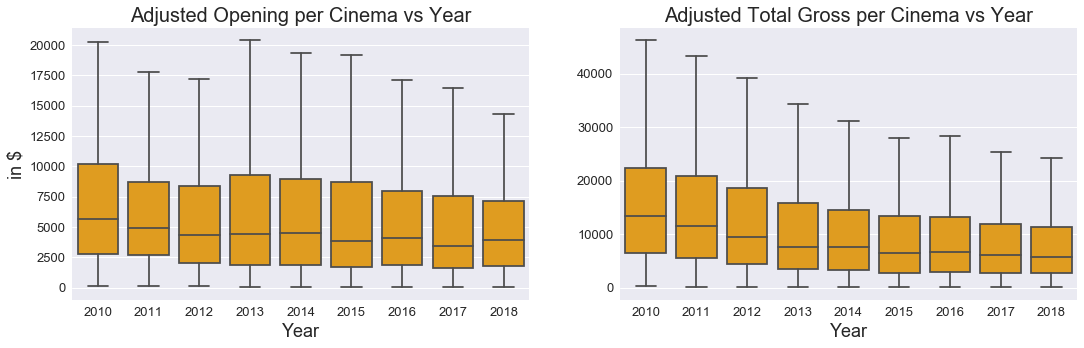

In [25]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.boxplot(x = 'year', y = 'adjusted_opening_per_cinema', showfliers = False, color = 'orange', data = pc)
plt.title("Adjusted Opening per Cinema vs Year", size=20)
plt.xlabel('Year', size=18)
plt.xticks(rotation=0, size=13)
plt.ylabel('in $', size=18)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.boxplot(x = 'year', y = 'adjusted_total_gross_per_cinema', showfliers = False, color = 'orange', data = pc)
plt.title("Adjusted Total Gross per Cinema vs Year", size=20)
plt.xlabel('Year', size=18)
plt.ylabel('')
plt.xticks(rotation=0, size=13)
plt.yticks(size=13);

* Adjusted opening seems to stay constant
* Adjusted total gross shows a downward trend

## Performance vs Genre

/Users/piocalderon/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


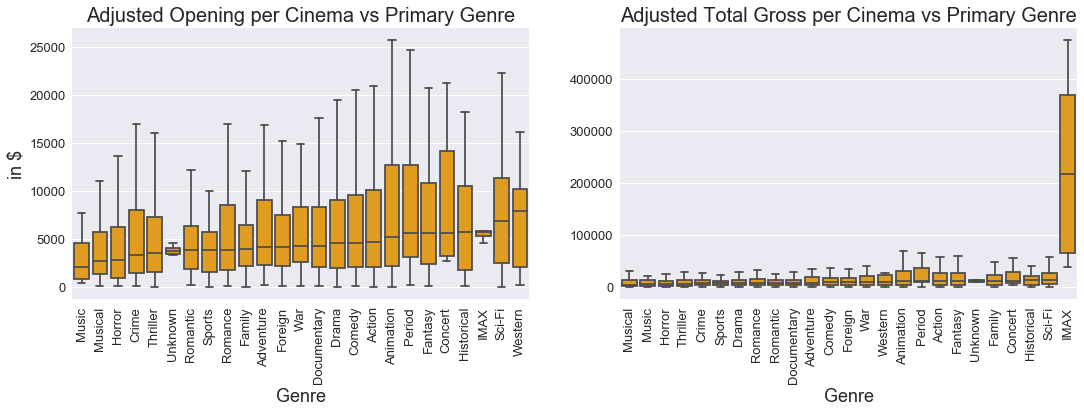

In [26]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
o1 = pc.groupby('genre1').median()['adjusted_opening_per_cinema'].sort_values().index
sns.boxplot(x = 'genre1', y = 'adjusted_opening_per_cinema', showfliers = False, color = 'orange', order = o1, data = pc)
plt.title("Adjusted Opening per Cinema vs Primary Genre", size=20)
plt.xlabel('Genre', size=18)
plt.xticks(size=13, rotation=90)
plt.ylabel('in $', size=18)
plt.yticks(size=13)

ax = fig.add_subplot(122)
o2 = pc.groupby('genre1').median()['adjusted_total_gross_per_cinema'].sort_values().index
sns.boxplot(x = 'genre1', y = 'adjusted_total_gross_per_cinema', showfliers = False, color = 'orange', order = o2, data = pc)
plt.title("Adjusted Total Gross per Cinema vs Primary Genre", size=20)
plt.xlabel('Genre', size=18)
plt.ylabel('')
plt.xticks(size=13, rotation=90)
plt.yticks(size=13);

* Western, Sci Fi, IMAX have highest median opening performance, while musicals and horror seem to perform badly on opening
* IMAX dominates adjusted total gross, followed by scifi and historical

## Performance vs Rating

/Users/piocalderon/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


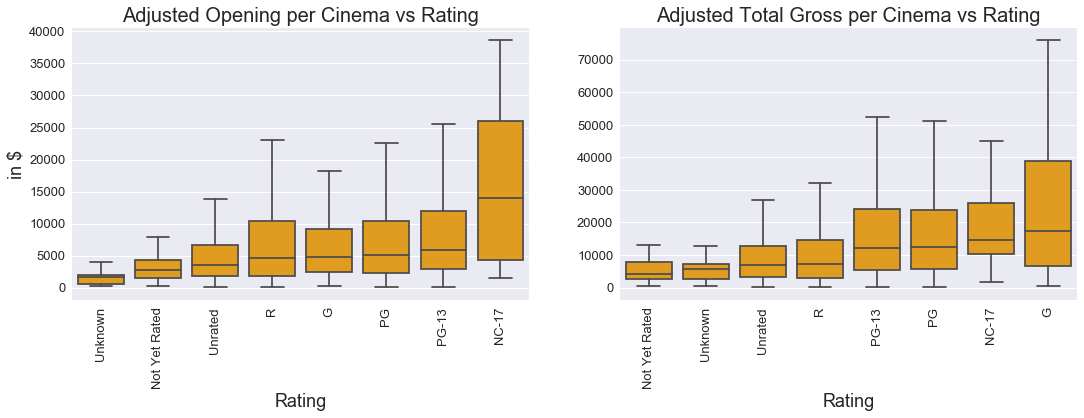

In [27]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
o1 = pc.groupby('rating').median()['adjusted_opening_per_cinema'].sort_values().index
sns.boxplot(x = 'rating', y = 'adjusted_opening_per_cinema', showfliers = False, color = 'orange', order = o1, data = pc)
plt.title("Adjusted Opening per Cinema vs Rating", size=20)
plt.xlabel('Rating', size=18)
plt.xticks(size=13, rotation=90)
plt.ylabel('in $', size=18)
plt.yticks(size=13)

ax = fig.add_subplot(122)
o2 = pc.groupby('rating').median()['adjusted_total_gross_per_cinema'].sort_values().index
sns.boxplot(x = 'rating', y = 'adjusted_total_gross_per_cinema', showfliers = False, color = 'orange', order = o2, data = pc)
plt.title("Adjusted Total Gross per Cinema vs Rating", size=20)
plt.xlabel('Rating', size=18)
plt.ylabel('')
plt.xticks(size=13, rotation=90)
plt.yticks(size=13);

* NC-17 has highest median adjusted opening
* G has highest adjusted total gross

## Performance vs Runtime

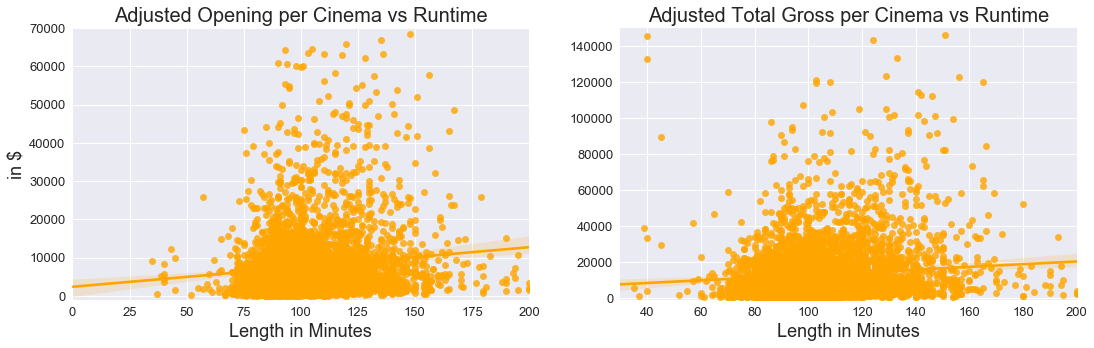

In [28]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'runtime', y = 'adjusted_opening_per_cinema', color = 'orange', data = pc)
plt.xlim(0, 200)
plt.ylim(-1000, 70000)
plt.title("Adjusted Opening per Cinema vs Runtime", size=20)
plt.xlabel('Length in Minutes', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'runtime', y = 'adjusted_total_gross_per_cinema', color = 'orange', data = pc)
plt.xlim(30, 200)
plt.ylim(-1000,150000)
plt.title("Adjusted Total Gross per Cinema vs Runtime", size=20)
plt.xlabel('Length in Minutes', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* Most successful movies tend to fall between 75 to 150 minutes in length

## Performance vs Distributor

/Users/piocalderon/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/piocalderon/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


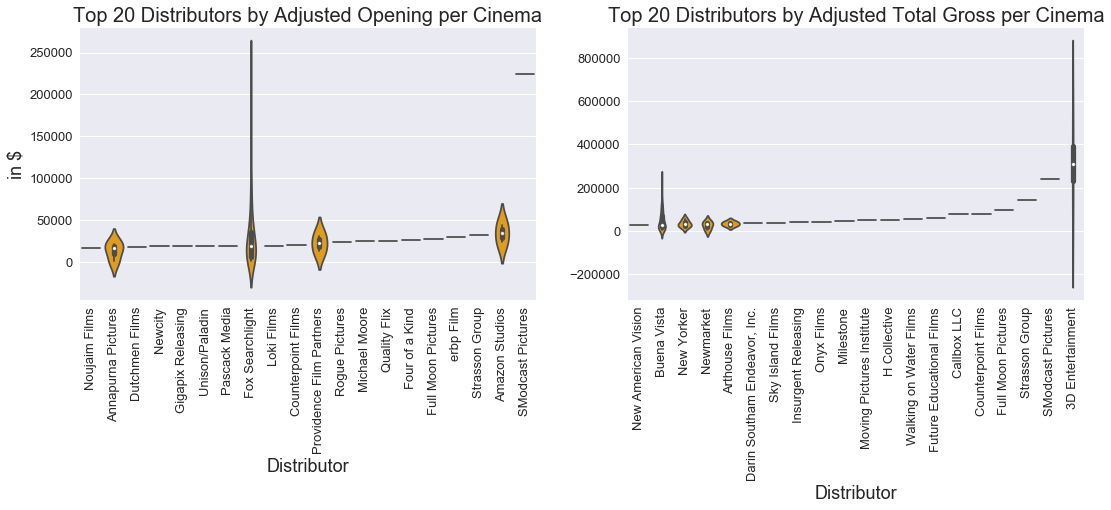

In [29]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
o1 = pc.groupby('distributor').median()['adjusted_opening_per_cinema'].dropna().sort_values().index[-20:]
dist1 = pc[pc['distributor'].isin(o1)]
sns.violinplot(x = 'distributor', y = 'adjusted_opening_per_cinema', showfliers = False, color = 'orange', order = o1, data = dist1)
plt.title("Top 20 Distributors by Adjusted Opening per Cinema", size=20)
plt.xlabel('Distributor', size=18)
plt.xticks(size=13, rotation=90)
plt.ylabel('in $', size=18)
plt.yticks(size=13)

ax = fig.add_subplot(122)
o2 = pc.groupby('distributor').median()['adjusted_total_gross_per_cinema'].dropna().sort_values().index[-20:]
dist2 = pc[pc['distributor'].isin(o2)]
sns.violinplot(x = 'distributor', y = 'adjusted_total_gross_per_cinema', showfliers = False, color = 'orange', order = o2, data = dist2)
plt.title("Top 20 Distributors by Adjusted Total Gross per Cinema", size=20)
plt.xlabel('Distributor', size=18)
plt.ylabel('')
plt.xticks(size=13, rotation=90)
plt.yticks(size=13);

## Performance vs Budget

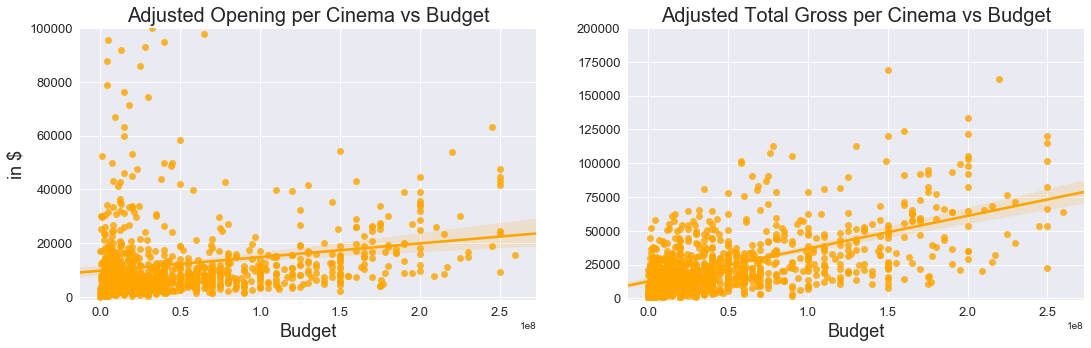

In [30]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'budget', y = 'adjusted_opening_per_cinema', color = 'orange', data = pc)
plt.ylim(-1000,100000)
plt.title("Adjusted Opening per Cinema vs Budget", size=20)
plt.xlabel('Budget', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'budget', y = 'adjusted_total_gross_per_cinema', color = 'orange', data = pc)
plt.ylim(-1000,200000)
plt.title("Adjusted Total Gross per Cinema vs Budget", size=20)
plt.xlabel('Budget', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* Some small-budget films with good opening performance (ex. Kings Speech, Black Swan, The Fighter)
* Some high-budget films with bad opening performance (ex. Tangled, Pirates of the Caribbean: On Stranger Tides	)
* Faint positive relation between budget and box office performance

## Performance vs Duration in Theater

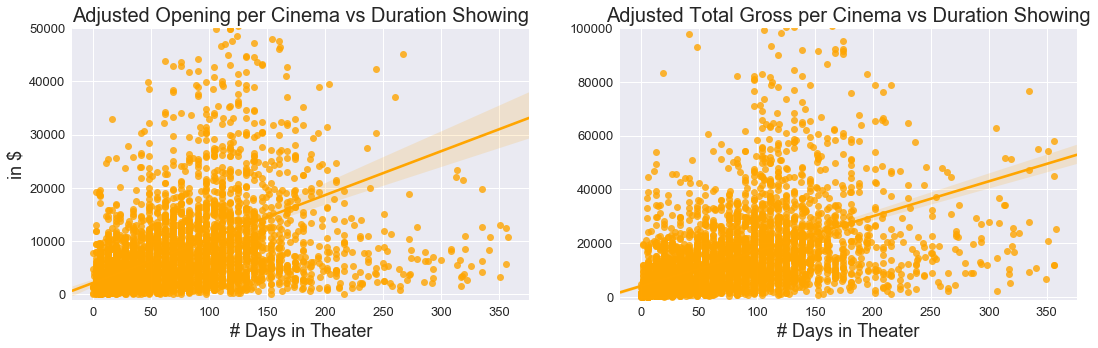

In [31]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'in_cinema', y = 'adjusted_opening_per_cinema', color = 'orange', data = pc)
plt.ylim(-1000,50000)
plt.title("Adjusted Opening per Cinema vs Duration Showing", size=20)
plt.xlabel('# Days in Theater', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'in_cinema', y = 'adjusted_total_gross_per_cinema', color = 'orange', data = pc)
plt.ylim(-1000,100000)
plt.title("Adjusted Total Gross per Cinema vs Duration Showing", size=20)
plt.xlabel('# Days in Theater', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* Very faint positive relation between budget and duration showing

## NLP Features

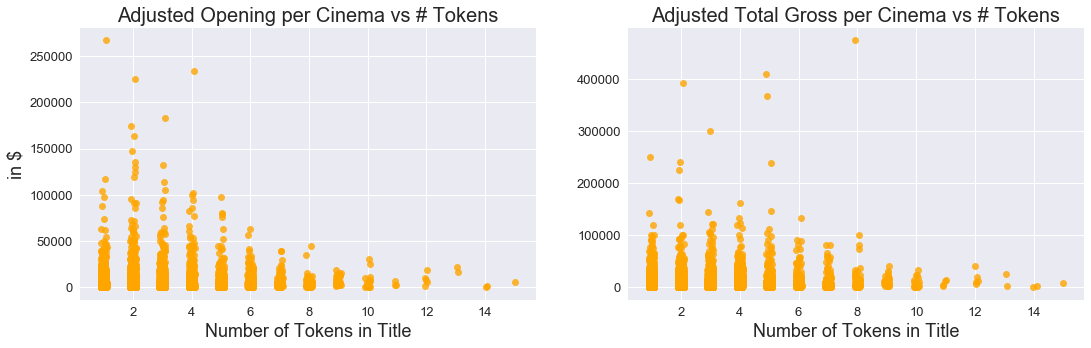

In [32]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'num_tokens', y = 'adjusted_opening_per_cinema', x_jitter=0.1, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Opening per Cinema vs # Tokens", size=20)
plt.xlabel('Number of Tokens in Title', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'num_tokens', y = 'adjusted_total_gross_per_cinema', x_jitter=0.1, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Total Gross per Cinema vs # Tokens", size=20)
plt.xlabel('Number of Tokens in Title', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* Interestingly, we see higher variance for small number of tokens
* Higher performance associated with lower # of tokens

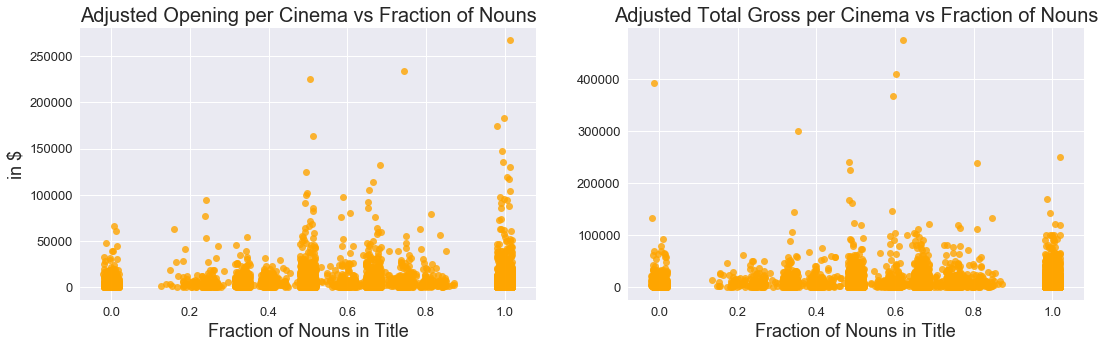

In [33]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'frac_nouns', y = 'adjusted_opening_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Opening per Cinema vs Fraction of Nouns", size=20)
plt.xlabel('Fraction of Nouns in Title', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'frac_nouns', y = 'adjusted_total_gross_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Total Gross per Cinema vs Fraction of Nouns", size=20)
plt.xlabel('Fraction of Nouns in Title', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* No apparent trend for fraction of nouns.

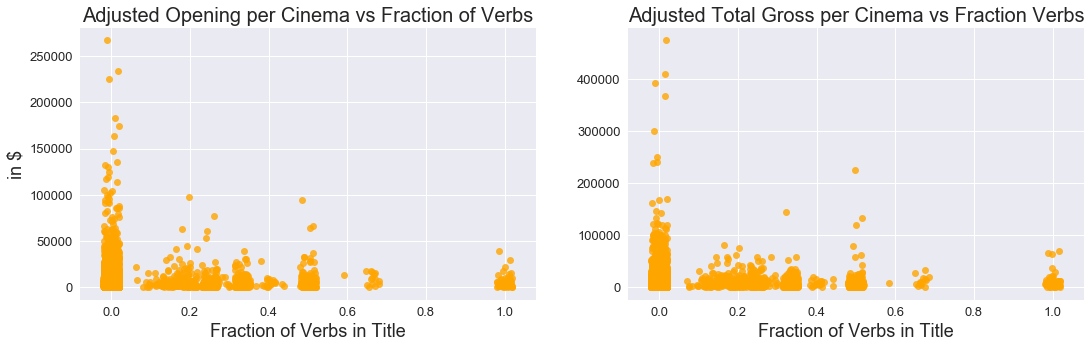

In [34]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'frac_verbs', y = 'adjusted_opening_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Opening per Cinema vs Fraction of Verbs", size=20)
plt.xlabel('Fraction of Verbs in Title', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'frac_verbs', y = 'adjusted_total_gross_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Total Gross per Cinema vs Fraction Verbs", size=20)
plt.xlabel('Fraction of Verbs in Title', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* Low verb count is associated with higher variability in box office performance

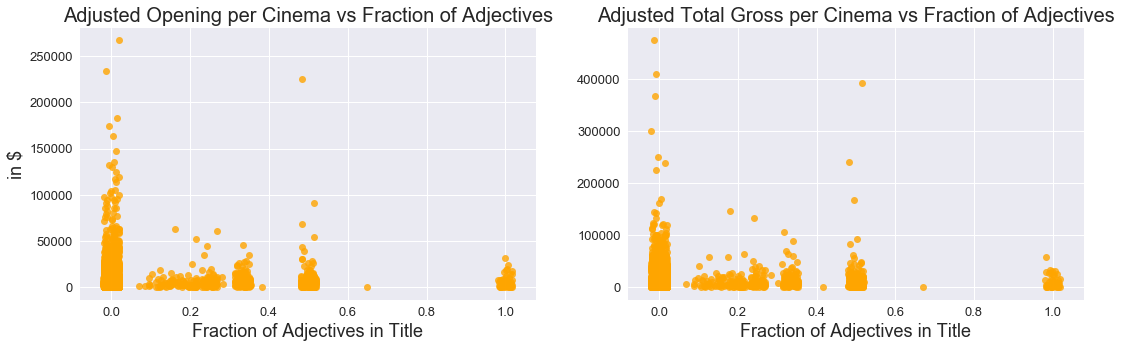

In [35]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'frac_adjectives', y = 'adjusted_opening_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Opening per Cinema vs Fraction of Adjectives", size=20)
plt.xlabel('Fraction of Adjectives in Title', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'frac_adjectives', y = 'adjusted_total_gross_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Total Gross per Cinema vs Fraction of Adjectives", size=20)
plt.xlabel('Fraction of Adjectives in Title', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* Low adjective count is associated with higher variability in box office performance

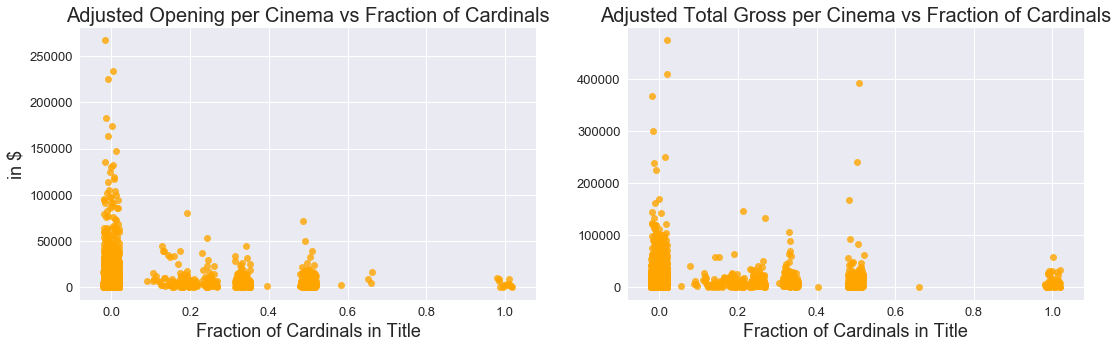

In [36]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'frac_cardinals', y = 'adjusted_opening_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Opening per Cinema vs Fraction of Cardinals", size=20)
plt.xlabel('Fraction of Cardinals in Title', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'frac_adjectives', y = 'adjusted_total_gross_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Total Gross per Cinema vs Fraction of Cardinals", size=20)
plt.xlabel('Fraction of Cardinals in Title', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* Low cardinal count is associated with higher variability in box office performance

## Title Word Clouds per Genre

In [129]:
# Let us look at the most frequently-occuring title words for best- 
# and worst-performing movies for the 5 genres with most number of movies
pc.groupby('genre1').count()['year'].sort_values(ascending=False).head()

genre1
Drama          1121
Documentary    1061
Foreign         766
Comedy          750
Action          388
Name: year, dtype: int64

In [96]:
def plot_best_and_worst_words_per_genre(genre = '', var = 'adjusted_total_gross_per_cinema'):
    
    if genre == '':
        genre_df = pc.dropna(subset = [var]).sort_values(var)
    else:
        genre_df = pc[pc['genre1'] == genre].dropna(subset = [var]).sort_values(var)
    worst = ' '.join(genre_df.head(100)['wiki'].values)
    best = ' '.join(genre_df.tail(100)['movie_title'].values)

    wordcloud_w = WordCloud().generate(worst)
    wordcloud_b = WordCloud().generate(best)

    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(wordcloud_w, interpolation='bilinear')
    plt.title('Wordcloud of 100 worst {} films'.format(genre), size=20)
    plt.axis("off");

    plt.subplot(122)
    plt.imshow(wordcloud_b, interpolation='bilinear')
    plt.title('Wordcloud of 100 best {} films'.format(genre), size=20)
    plt.axis("off");


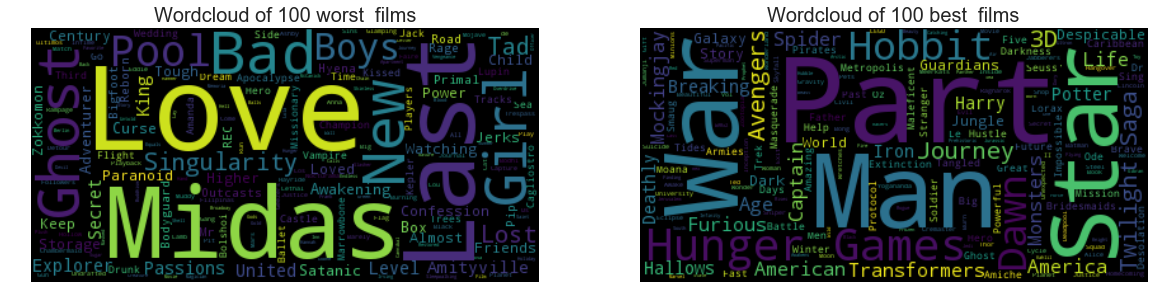

In [794]:
# Across all movies
plot_best_and_worst_words_per_genre()

* Worst words: Love, Girl, Midas, Bad
* Best words: Avengers, War, Beast, Hour

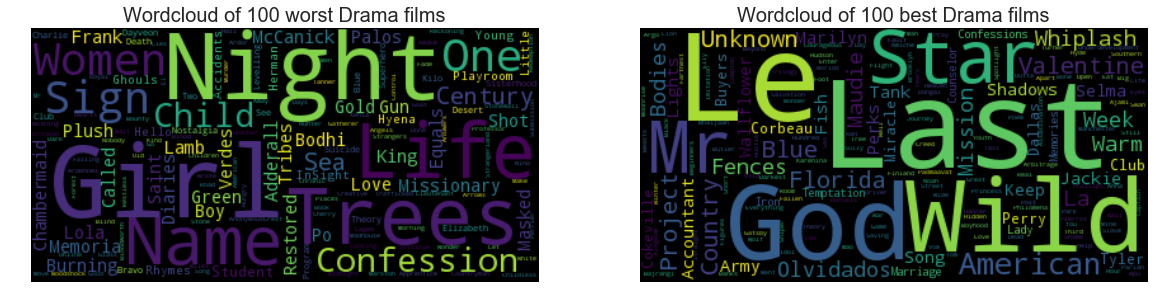

In [795]:
# Across drama films
plot_best_and_worst_words_per_genre(genre = 'Drama')

* Worst words: Night, Girl, Life, Trees
* Best words: Le, Last, God, Wild

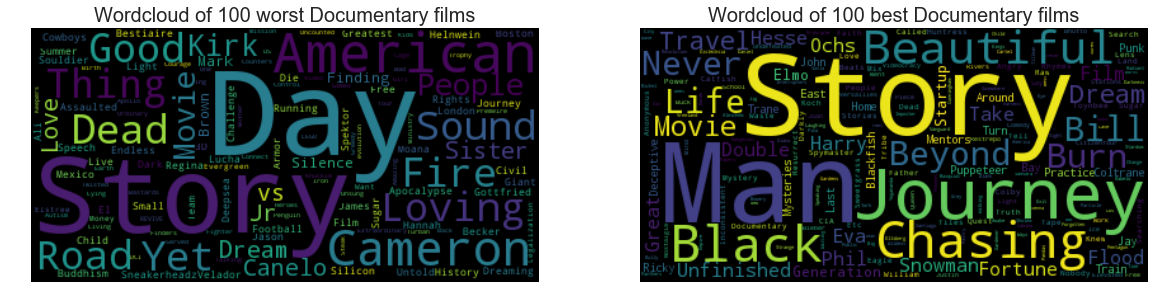

In [796]:
# Across documentary films
plot_best_and_worst_words_per_genre(genre = 'Documentary')

* Worst words: Story, Day, American
* Best words: Story, Man, Journey, Chasing

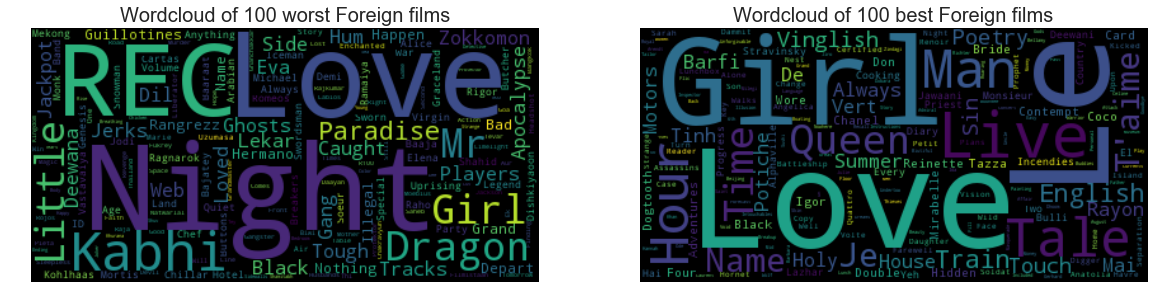

In [798]:
# Across foreign films
plot_best_and_worst_words_per_genre(genre = 'Foreign')

* Worst words: Night, Love, REC
* Best words: Girl, Love, Le

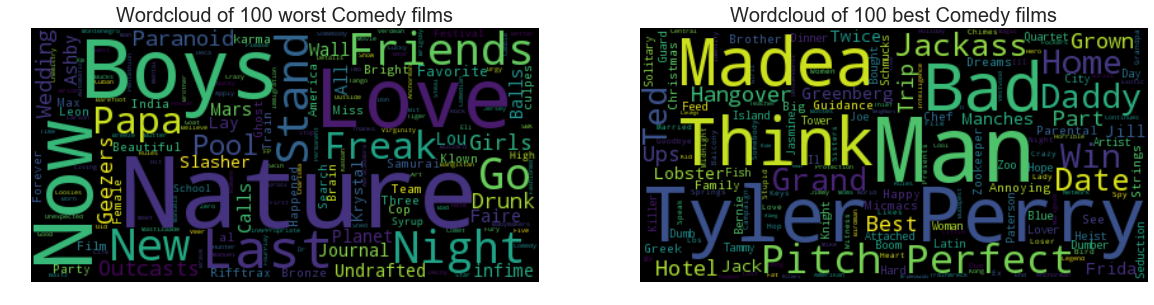

In [799]:
# Across comedy films
plot_best_and_worst_words_per_genre(genre = 'Comedy')

* Worst words: Nature, Now, Boys, Love
* Best words: Man, Tyler, Perry, Madea

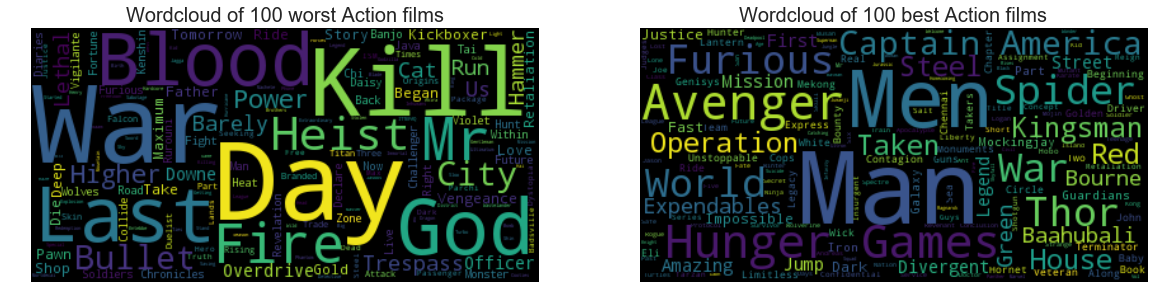

In [800]:
# Across action films
plot_best_and_worst_words_per_genre(genre = 'Action')

* Worst words: Kill, War, Last, Day
* Best words: Men, Man, Avenger

## Synopsis Word Clouds per Genre

In [131]:
# Let us look at the most frequently-occuring synopsis words for best- 
# and worst-performing movies for the 5 genres with most number of movies
pc.groupby('genre1').count()['year'].sort_values(ascending=False).head()

genre1
Drama          717
Comedy         508
Foreign        483
Action         318
Documentary    224
Name: year, dtype: int64

In [44]:
def plot_best_and_worst_words_per_genre(genre = '', var = 'adjusted_total_gross_per_cinema'):
    
    if genre == '':
        genre_df = pc.dropna(subset = [var]).sort_values(var)
    else:
        genre_df = pc[pc['genre1'] == genre].dropna(subset = [var]).sort_values(var)
    worst = ' '.join(genre_df.head(100)['wiki_tokenized_words_set_string'].values)
    best = ' '.join(genre_df.tail(100)['wiki_tokenized_words_set_string'].values)

    wordcloud_w = WordCloud().generate(worst)
    wordcloud_b = WordCloud().generate(best)

    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(wordcloud_w, interpolation='bilinear')
    plt.title('Wordcloud of 100 worst {} films'.format(genre), size=20)
    plt.axis("off");

    plt.subplot(122)
    plt.imshow(wordcloud_b, interpolation='bilinear')
    plt.title('Wordcloud of 100 best {} films'.format(genre), size=20)
    plt.axis("off");
    
    # worst is a string of the concatenated set of words in the worst 100 movies
    # best is a string of the concatenated set of words in the best 100 movies
    return worst, best

In [46]:
def get_worst_and_best_words(worst, best, k=10):
    """
        This function does the following procedure:
            1. Remove human names, punctuation, stopwords from the input strings worst and best
                worst: string of the concatenated set of words in the worst 100 movies
                best: string of the concatenated set of words in the best 100 movies
            2. Obtain the frequency distribution of words in worst (worst_fd) and the frequency distribution
                of words in best (best_fd)
            3. Get the 50 most frequent words from worst_fd (worst_50). Same for best_fd (best_50).
            4. Get the top k words by count that appear in worst_50 but do not appear in best_50 (worst_unique).
                Do the same for best_50, but compare against worst_50 (best_50).
            5. Return dataframe of worst words, # of movies in the worst 100 movies that contain the worst words,
                # of movies in the best 100 movies that contain the worst words, best words, # of movies in the
                best 100 movies that contain the best words, # of movies in the best 100 movies that contain the best words
    """
    
    # get list of human names from https://stackoverflow.com/questions/1803628/raw-list-of-person-names
    # we filter these out
    human_names = pd.read_csv('data/census-derived-all-first.txt', delimiter=r'\s*', header=None, usecols=[0], engine='python').iloc[:, 0].str.lower().values

    no_punc_pattern = r'[^0-9a-z\- ]'
    
    # get list of english words
    english_vocab = set(w.lower() for w in words.words())
    # get list of stopwords
    stops = stopwords.words('english')    
    
    # get Frequency distribution from a string x
    get_fd = lambda x: FreqDist([x for x in word_tokenize(re.sub(no_punc_pattern, '', x.lower())) if (x not in stops and x in english_vocab and x not in human_names)])
    
    worst_fd = get_fd(worst)
    best_fd = get_fd(best)
    
    # get top 50 most frequent words from 100 worst movies' synopses
    worst_50 = worst_fd.most_common(50)
    # get top 50 most frequent words from 100 best movies' synopses
    best_50 = best_fd.most_common(50)
    
    # get top k words by count that appear in worst_50 that do not appear in best_50
    # get the count of these words in the 100 worst movies
    # get the count of these words in the 100 best movies
    worst_unique = [(w[0], w[1], best_fd[w[0]]) for w in worst_50 if w[0] not in [x[0] for x in best_50]][:k]

    # get top k words by count that appear in best_50 that do not appear in worst_50
    # get the count of these words in the 100 worst movies
    # get the count of these words in the 100 best movies
    best_unique = [(w[0], worst_fd[w[0]], w[1]) for w in best_50 if w[0] not in [x[0] for x in worst_50]][:k]
    
    # return dataframe of top 10 words for worst/best
    return pd.DataFrame(np.hstack([worst_unique, best_unique]), \
              columns= ['worst words', '# worst movies with word', '# best movies with word', 'best words', '# worst movies with word', '# best movies with word'])

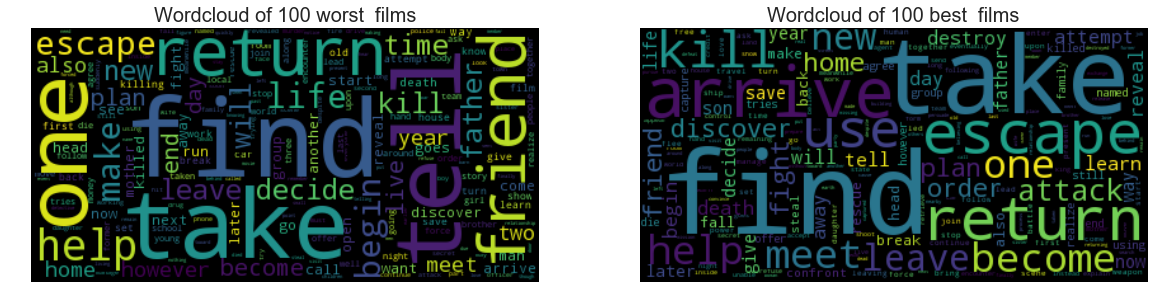

In [47]:
# Across all movies
worst, best = plot_best_and_worst_words_per_genre()

There is a lot of overlap in the wordclouds in the worst/best movies, so let's look at the words that occurs uniquely in the worst synopses and those that occur uniquely in the best synopses

In [48]:
get_worst_and_best_words(worst, best)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py:2218: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/piocalderon/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py:2220: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


worst words # worst movies with word # best movies with word best words  \
0         get                       30                      24      fight   
1        goes                       26                      23  meanwhile   
2        next                       25                      19      leave   
3        film                       23                      16     become   
4      friend                       22                      26     attack   
5       night                       22                      23      world   
6     another                       21                      26      still   
7      people                       21                      22   together   
8        make                       20                      19     arrive   
9       house                       19                      23    leaving   

  # worst movies with word # best movies with word  
0                       15                      39  
1                       13                      38  
2                       14                      38  
3                       11                      38  
4                        9                      36  
5                       14                      36  
6                       13                      35  
7                       15                      33  
8                        5                      32  
9                       10                      31

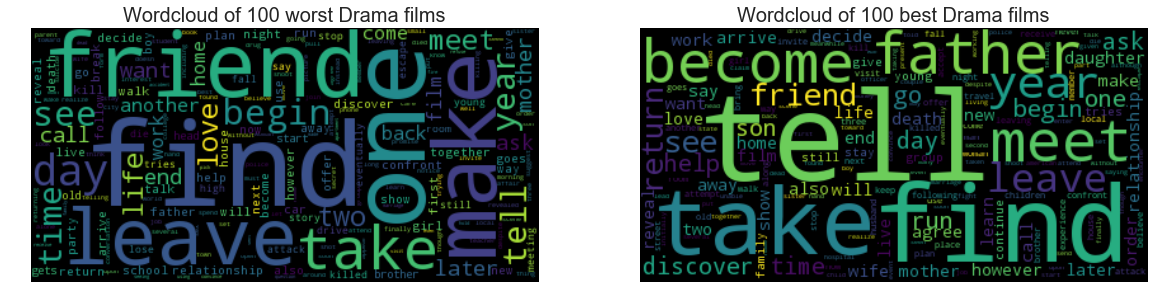

In [49]:
# Across drama films
worst, best = plot_best_and_worst_words_per_genre(genre = 'Drama')

In [50]:
get_worst_and_best_words(worst, best)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py:2218: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/piocalderon/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py:2220: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


worst words # worst movies with word # best movies with word best words  \
0         get                       32                      23     family   
1      school                       30                      16   daughter   
2        work                       23                      24     return   
3         car                       22                      24      three   
4         sex                       22                      13      still   
5       going                       21                      12     become   
6       party                       21                      15      woman   
7        come                       20                      19  following   
8      police                       20                      24      group   
9    revealed                       19                      12      would   

  # worst movies with word # best movies with word  
0                       17                      43  
1                       11                      38  
2                       14                      35  
3                       16                      34  
4                       17                      30  
5                       11                      29  
6                       17                      29  
7                       10                      28  
8                       11                      28  
9                       14                      26

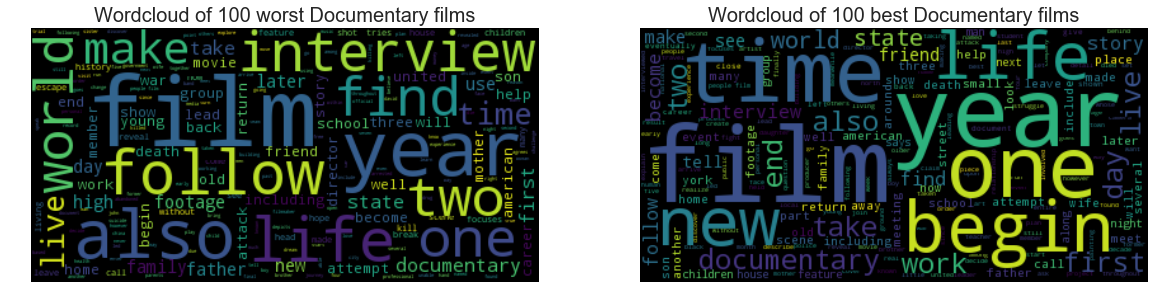

In [51]:
# Across documentary films
worst, best = plot_best_and_worst_words_per_genre(genre = 'Documentary')

In [52]:
get_worst_and_best_words(worst, best)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py:2218: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/piocalderon/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py:2220: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


worst words # worst movies with word # best movies with word  best words  \
0        high                       17                       9         end   
1      united                       14                       9        york   
2    american                       14                      12     another   
3        help                       13                      12        away   
4       group                       13                       8  eventually   
5      mother                       13                      12       small   
6         war                       12                       8         way   
7       movie                       12                       6      around   
8     history                       12                       7        next   
9       house                       11                      11      become   

  # worst movies with word # best movies with word  
0                        9                      19  
1                        4                      17  
2                        9                      17  
3                        6                      16  
4                        5                      15  
5                        4                      13  
6                        9                      13  
7                        4                      13  
8                        8                      12  
9                        9                      12

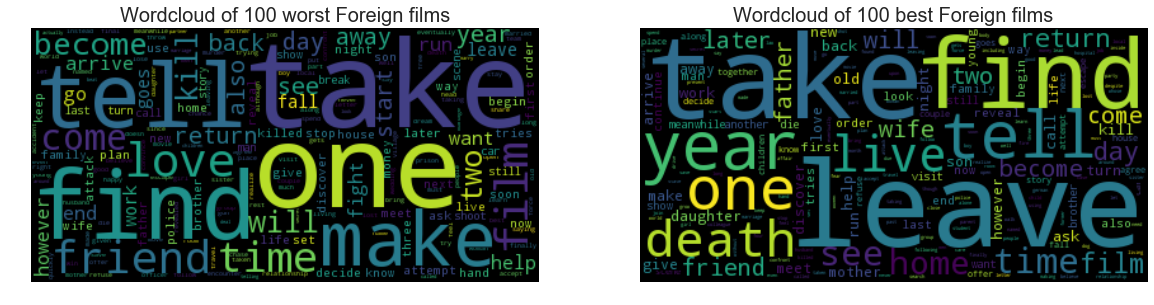

In [53]:
# Across foreign films
worst, best = plot_best_and_worst_words_per_genre(genre = 'Foreign')

In [54]:
get_worst_and_best_words(worst, best)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py:2218: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/piocalderon/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py:2220: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


worst words # worst movies with word # best movies with word best words  \
0        make                       30                      18      death   
1      become                       30                      12     leaves   
2        kill                       25                      17        new   
3        come                       25                      19   daughter   
4       fight                       25                       6        old   
5       money                       25                      17    becomes   
6       comes                       25                      15      woman   
7       three                       23                      19    leaving   
8     married                       23                      15      would   
9         men                       22                      17     return   

  # worst movies with word # best movies with word  
0                       16                      40  
1                       19                      32  
2                       20                      31  
3                       21                      30  
4                       18                      29  
5                       21                      28  
6                       14                      25  
7                       14                      23  
8                       20                      21  
9                       20                      21

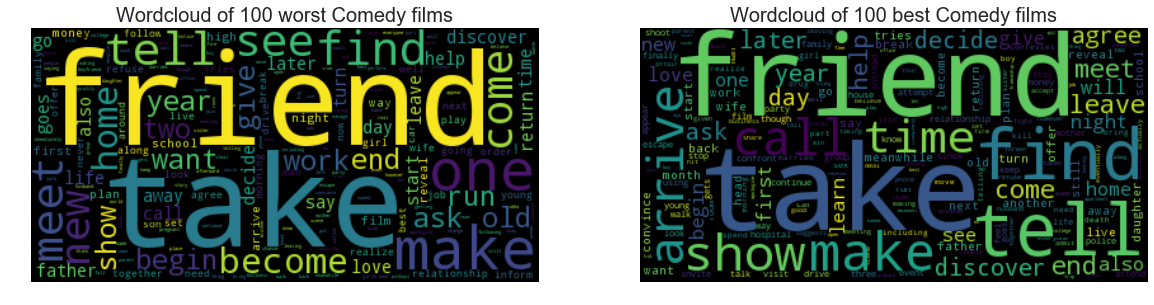

In [55]:
# Across action films
worst, best = plot_best_and_worst_words_per_genre(genre = 'Comedy')

In [56]:
get_worst_and_best_words(worst, best)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py:2218: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/piocalderon/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py:2220: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


worst words # worst movies with word # best movies with word  best words  \
0       money                       23                      24        next   
1        meet                       22                      26       party   
2        well                       22                      22   meanwhile   
3        high                       21                      22     however   
4       going                       21                      26       still   
5        best                       20                      23      become   
6       comes                       20                      25     becomes   
7         end                       19                      26        head   
8       along                       19                      17     finally   
9        room                       18                      25  eventually   

  # worst movies with word # best movies with word  
0                       18                      47  
1                       16                      37  
2                       12                      35  
3                       15                      35  
4                       16                      34  
5                       16                      33  
6                       17                      33  
7                        7                      31  
8                       15                      30  
9                       15                      30

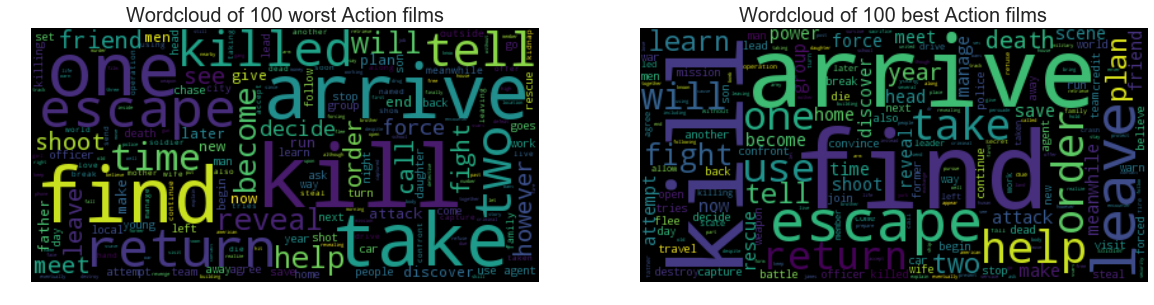

In [57]:
# Across action films
worst, best = plot_best_and_worst_words_per_genre(genre = 'Action')

In [58]:
get_worst_and_best_words(worst, best)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py:2218: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/piocalderon/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py:2220: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


worst words # worst movies with word # best movies with word best words  \
0     however                       34                      28      scene   
1          go                       33                      25      group   
2         get                       28                      25     former   
3        goes                       27                      27        use   
4        shot                       27                      20     battle   
5      people                       26                      19     arrive   
6       night                       26                      20      world   
7       local                       26                      19    attempt   
8         car                       25                      28     return   
9        wife                       25                      26     leader   

  # worst movies with word # best movies with word  
0                       11                      38  
1                       20                      36  
2                       16                      36  
3                       14                      34  
4                       11                      34  
5                       18                      32  
6                       17                      32  
7                       14                      32  
8                       18                      31  
9                       10                      31

The wordclouds and dataframes above show the prevalent words in the best and worst performing films per genre. Let's try to build a model to predict box office performance from title content, Wikipedia synopsis, and metadata.

# Part 4: Predict Performance Based on Word Content + Metadata
**Task**: Build a model that takes as input the words in the movie title, Wikipedia synopsis, metadata and outputs a prediction on box office performance. Here we will consider only the adjusted total gross per cinema. Same analysis can be done for opening.

**Features Considered**:
* Metadata features
* NLP POS Frequency features of title
* Word2Vec word vector of title (300 feats)
* TF-IDF unigram and bigram features of title
* Word2Vec word vector of synopsis (300 feats)
* TF-IDF unigram features of title

**General Approach**: Use penalized linear regression (Ridge & Lasso) since feature space is high-dimensional and sparse. We then use the coefficient of the features to rank the features according to their effect on box office performance.

In [367]:
def split_dataset_for_genre(pc, genre = '', var = 'adjusted_total_gross_per_cinema', w2v = True, whole = False):
    """
        Split train and tests sets for the specific genre
        
        Input:
            pc : dataframe of features
            genre : genre to filter
            var : box office performance metric
            w2v : whether to include word2vec features
            whole: whether to train on whole dataset or not
        Output:
            X_train : input training set
            X_test : input test set
            y_train : output training set
            y_test : output test set
            column_names : list of feature names
    """
    
    # check whether genre is provided
    # if yes, filter pc by genre
    if genre == '':
        pc = pc
    else:
        pc = pc[pc['genre1'] == genre]
    
    # only retain rows with non-null performance metric
    pc = pc[~pc[var].isnull()]
    
    # collect metadata features
    metadata_features = pd.concat(
          [pc['runtime'],
           pc['budget'],
           pc['in_cinema'],
           pd.get_dummies(pc['rating']),
           pd.get_dummies(pc['genre1'], prefix = 'genre1'), 
           pd.get_dummies(pc['genre2'], prefix = 'genre2')
           ], axis=1)

    # collect nlp frequency features
    nlp_features = pc[['num_tokens',
        'frac_nouns',
        'frac_verbs',
        'frac_adjectives',
        'frac_cardinals',
        'movie_title',
        'wiki_synopsis']]
    
    # whether to include word2vec features
    # the w2v features tend to overpower tfidf features in the coefficients
    # of the regression
    # the point of the exercise is to see how word content correlates with box
    # office performance. it is very hard to interpret these vectors so 
    # I made it optional to include them
    if w2v:
        word2vec_features = pc.loc[:,['wv' in x for x in pc.columns]]
        feature_set = [metadata_features, nlp_features, word2vec_features]
    else:
        feature_set = [metadata_features, nlp_features]
    
    X = pd.concat(feature_set, axis=1)
        
    if whole:
        X_train = X
        y_train = pc[var]
    else:
        # split 70-30 train test sets
        X_train, X_test, y_train, y_test = train_test_split(X,
                pc[var], test_size=0.3, random_state=0)

    # obtain tfidf representation for words in the training set
    # only consider up to 2-grams, and filter out tokens appearing in < 4 titles
    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 4)
    tfidf_features = tfidf.fit_transform(X_train['movie_title'].values)
    tfidf_df = pd.DataFrame(tfidf_features.toarray(), index = X_train.index,
             columns=['title_' + x for x in tfidf.vocabulary_.keys()])

    # tfidf for the synopsis
    wiki_tfidf = TfidfVectorizer(stop_words='english', min_df = 20)
    wiki_tfidf_features = wiki_tfidf.fit_transform(X_train['wiki_synopsis'].values)
    wiki_tfidf_df = pd.DataFrame(wiki_tfidf_features.toarray(), index = X_train.index,
             columns=['synopsis_' + x for x in wiki_tfidf.vocabulary_.keys()])
    
    # append tfidf dataframe to training df
    X_train = pd.concat([X_train, tfidf_df, wiki_tfidf_df], axis=1)
    X_train.drop(columns=['movie_title', 'wiki_synopsis'], inplace=True)
    
    column_names = X_train.columns
    pad = X_train.mean()
    
    # fill NAs with the column mean
    X_train = X_train.fillna(pad)
    
    # I'm not sure if it's a bug with fillna, but there are still some 
    # columns that have NA. We fill these columns with their mean.
    desc = X_train.describe()
    null_cols = desc.columns[(desc.iloc[0,:] != X_train.shape[0]).values]
    for i in null_cols:
        X_train[i] = X_train[i].fillna(pad[i])
    
    # standardize rows
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    
    if whole:
        return X_train, None, y_train, None, column_names
    
    # get tfidf representation of test set
    tfidf_features_test = tfidf.transform(X_test['movie_title'].values)
    tfidf_df_test = pd.DataFrame(tfidf_features_test.toarray(), \
            index = X_test.index, columns=tfidf_df.columns)
    wiki_tfidf_features_test = wiki_tfidf.transform(X_test['wiki_synopsis'].values)
    wiki_tfidf_df_test = pd.DataFrame(wiki_tfidf_features_test.toarray(), \
            index = X_test.index, columns=wiki_tfidf_df.columns)
    
    X_test = pd.concat([X_test, tfidf_df_test, wiki_tfidf_df_test], axis=1)
    X_test.drop(columns=['movie_title', 'wiki_synopsis'], inplace=True)
    
    X_test = X_test.fillna(X_train.mean())
    
    desc = X_test.describe()
    null_cols = desc.columns[(desc.iloc[0,:] != X_test.shape[0]).values]
    for i in null_cols:
        X_test[i] = X_test[i].fillna(pad[i])

    X_test = ss.transform(X_test)
    
    return X_train, X_test, y_train, y_test, column_names

In [493]:
def train_model(modeltype, X_train, y_train):
    """
        Train chosen model.
        
        Input:
            modeltype : whether 'lasso' or 'ridge'
            X_train : input training set
            y_train : output training set
        Output:
            model : trained linear regression model
    """

    if modeltype == 'lasso':
        model = LassoCV()
    elif modeltype == 'ridge':
        model = RidgeCV(alphas=[0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50., 100.0, 500.0])
    model.fit(X_train, y_train)
    return model

In [478]:
def evaluate_model(X, y):
    """
        Evaluate trained model.
        
        Input:
            X : input to model
            y : output to predict
    """
    
    print('R**2 : {}'.format(model.score(X, y)))
    print('RMSE : {}'.format(np.sqrt(mean_squared_error(y, model.predict(X)))))   
    plt.figure(figsize=(10,6))
    plt.plot(range(len(y)), y - model.predict(X), 'o', alpha = 0.5)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.ylabel('Residual', size=20)

In [370]:
def plot_most_relevant_features(model, column_names, n=15):
    """
        Plot the features which have the highest effect on
        box office performance based on the mode.
        
        Input:
            model : trained LR model
            column_names : list of features
            n : number of features to include (in one direction)
    """
    
    coef_sorted = list(model.coef_[np.argsort(-model.coef_)])
    columns_sorted = list(column_names[np.argsort(-model.coef_)])

    plt.figure(figsize=(10,6))
    plt.bar(range(2*n), coef_sorted[:n] + coef_sorted[-n:])
    plt.xticks(range(2*n), columns_sorted[:n] + columns_sorted[-n:], rotation=270, size=15)
    plt.yticks(size=15)
    plt.ylabel('Coefficient', size=20)
    plt.title('Top 10 + & - contributing variables', size=21);

We perform various experiments in the following:
* build model for all genres, with and without word2vec features
* build model for {Documentaries, Action}, with and without word2vec features


## Models A: All genres, no w2v features

In [500]:
# 70-30 train-test split
X_train, X_test, y_train, y_test, _ = split_dataset_for_genre(pc, w2v=False)

In [501]:
# whole dataset
X, _, y, _, column_names = split_dataset_for_genre(pc, w2v=False, whole=True)

### Model A.1: Ridge

In [502]:
model = train_model('ridge', X_train, y_train);

R**2 : 0.9573140002413522
RMSE : 3681.3027978195096


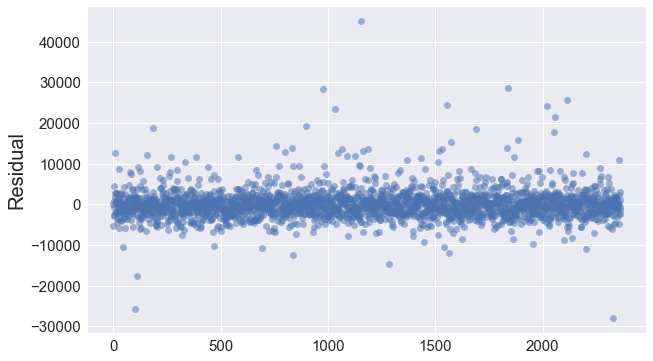

In [503]:
evaluate_model(X_train, y_train)

R**2 : -0.143313740439988
RMSE : 17645.494583661886


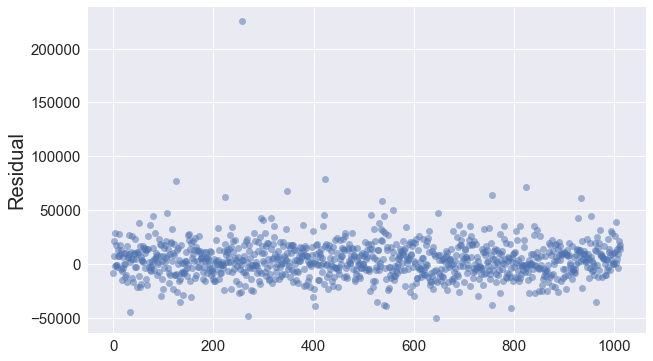

In [504]:
evaluate_model(X_test, y_test)

R**2 : 0.9610858721202613
RMSE : 3439.1240624197


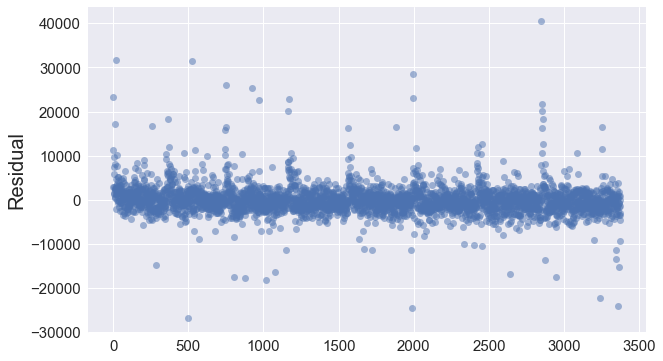

In [505]:
# train on the whole dataset
model = train_model('ridge', X, y);
evaluate_model(X, y)

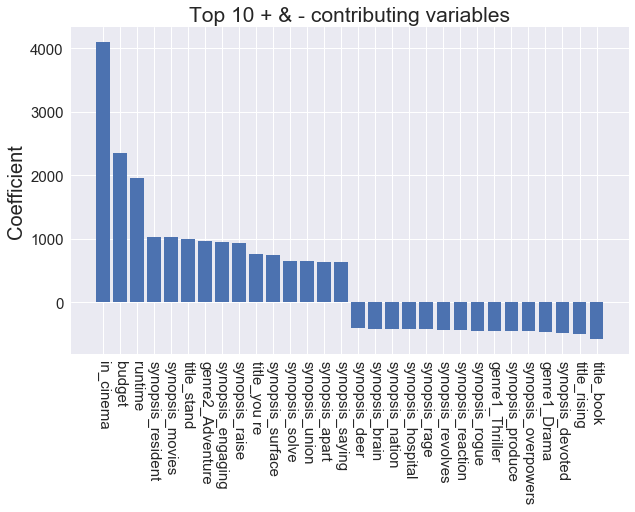

In [506]:
plot_most_relevant_features(model, column_names)

\+ coeff: resident > movies > stand (title) > engaging

\- coeff: book (title) < rising (title) < devoted

### Model A.2: Lasso

In [378]:
model = train_model('lasso', X_train, y_train);

R**2 : 0.4759625334947903
RMSE : 12898.522966067376


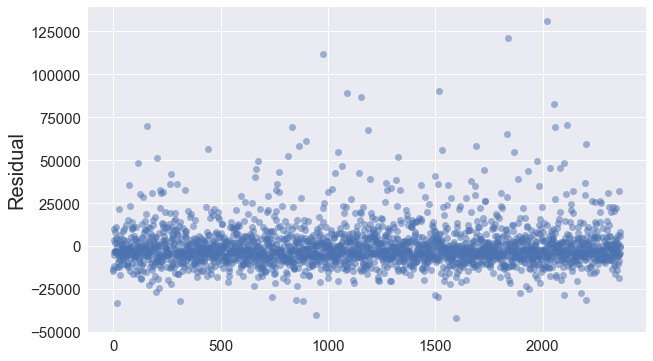

In [379]:
evaluate_model(X_train, y_train)

R**2 : 0.23165269536066435
RMSE : 14465.382110851917


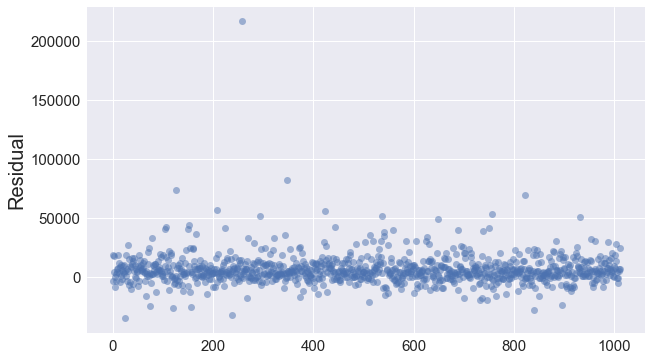

In [380]:
evaluate_model(X_test, y_test)

R**2 : 0.48699481060845795
RMSE : 12486.912574168775


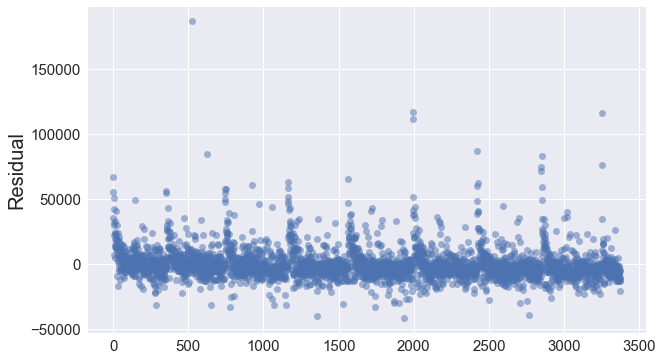

In [381]:
model = train_model('lasso', X, y);
evaluate_model(X, y)

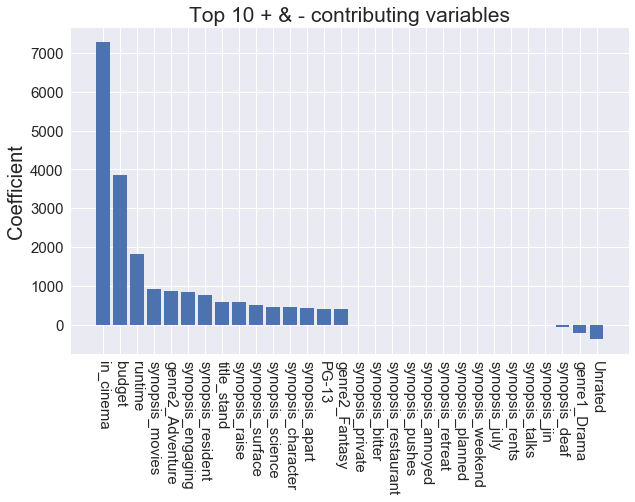

In [382]:
plot_most_relevant_features(model, column_names)

\+ coeff: movies > engaging > resident > stand (title)

\- coeff: deaf < jin < talks < rents

## Models B: Documentary, no w2v features

In [507]:
X_train, X_test, y_train, y_test, _ = split_dataset_for_genre(pc, 'Documentary', w2v=False)
X, _, y, _, column_names = split_dataset_for_genre(pc, 'Documentary', w2v=False, whole=True)

### Model B.1: Ridge

In [508]:
model = train_model('ridge', X_train, y_train);

R**2 : 0.38953468018204573
RMSE : 8515.644827711118


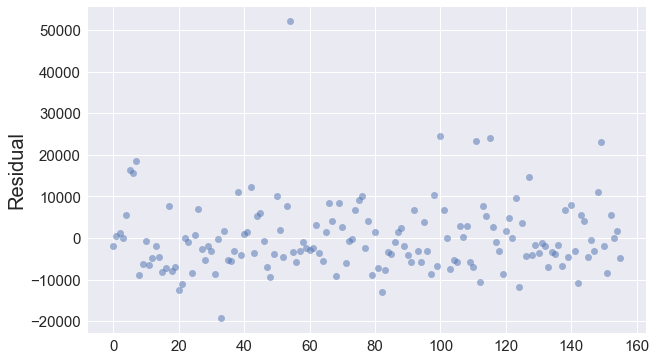

In [509]:
evaluate_model(X_train, y_train)

R**2 : -0.07002833995104507
RMSE : 12891.902732862383


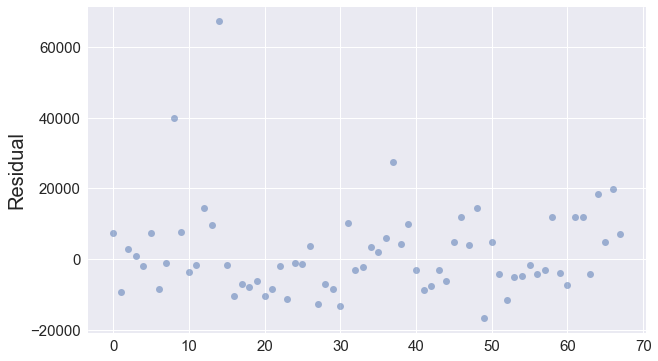

In [510]:
evaluate_model(X_test, y_test)

R**2 : 0.2550667751535143
RMSE : 9848.955133267184


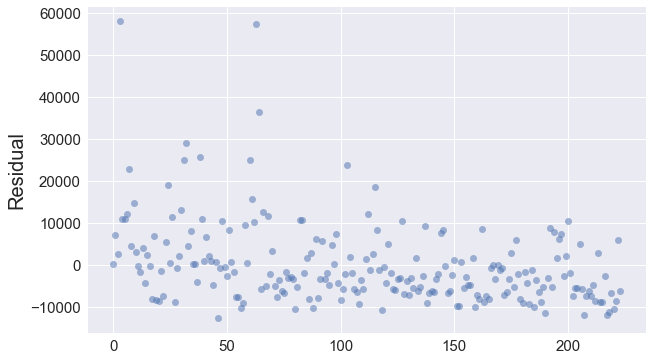

In [511]:
model = train_model('ridge', X, y);
evaluate_model(X, y)

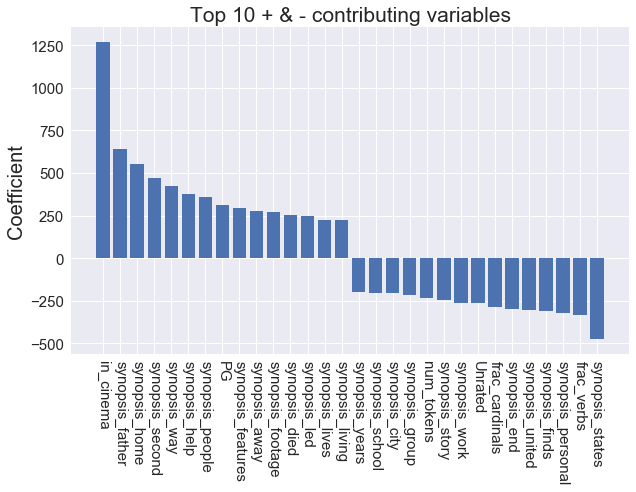

In [512]:
plot_most_relevant_features(model, column_names)

\+ coeff: father > home > second

\- coeff: states < personal < finds

### Model B.2: Lasso

In [389]:
model = train_model('lasso', X_train, y_train);

R**2 : 0.21708592350502132
RMSE : 9643.70888432852


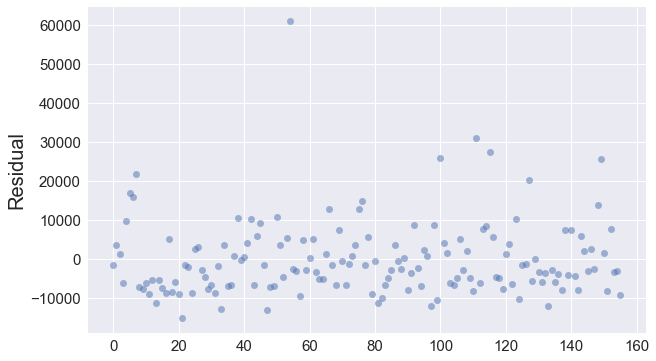

In [390]:
evaluate_model(X_train, y_train)

R**2 : -0.011878857949935151
RMSE : 12536.711765809318


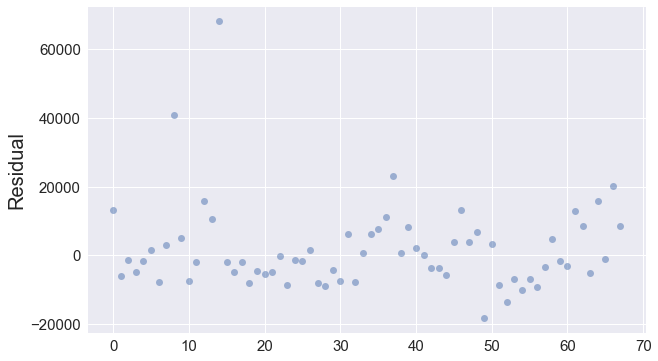

In [391]:
evaluate_model(X_test, y_test)

R**2 : 0.2941387963260502
RMSE : 9587.185772753612


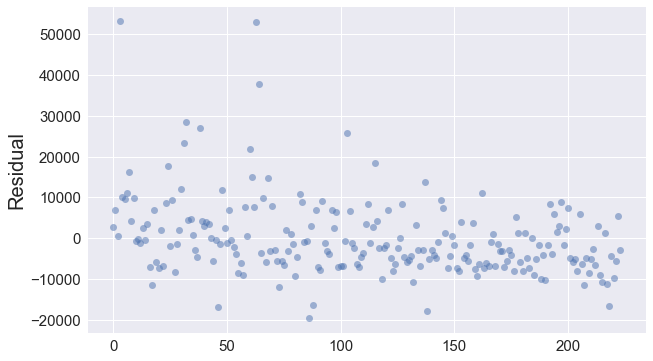

In [392]:
model = train_model('lasso', X, y);
evaluate_model(X, y)

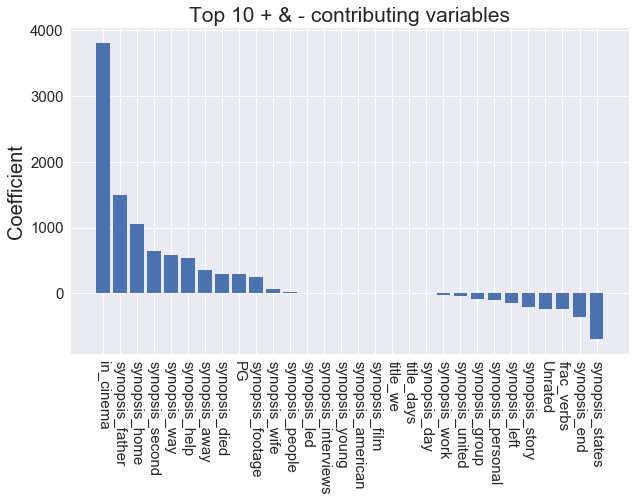

In [393]:
plot_most_relevant_features(model, column_names)

\+ coeff: father > home > second

\- coeff: states < end < story

## Models C: Action, no w2v features

In [513]:
X_train, X_test, y_train, y_test, _ = split_dataset_for_genre(pc, 'Action', w2v=False)
X, _, y, _, column_names = split_dataset_for_genre(pc, 'Action', w2v=False, whole=True)

### Model C.1: Ridge

In [514]:
model = train_model('ridge', X_train, y_train);

R**2 : 0.999999998529624
RMSE : 1.0136797312750265


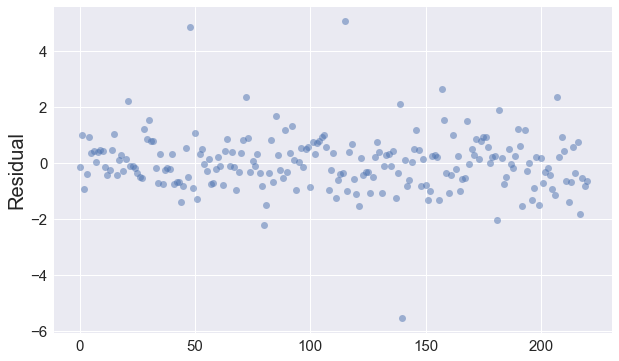

In [515]:
evaluate_model(X_train, y_train)

R**2 : -0.21478497441335542
RMSE : 31943.622207032353


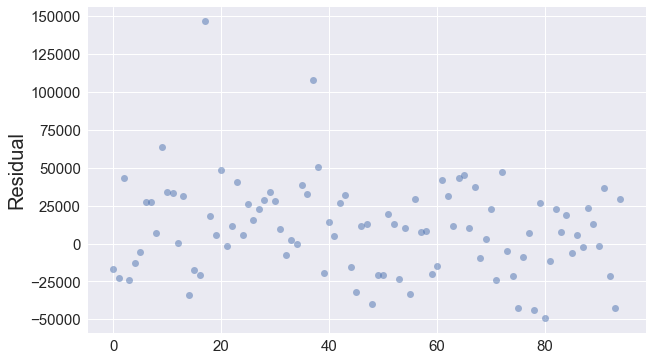

In [516]:
evaluate_model(X_test, y_test)

R**2 : 0.8489523829743673
RMSE : 10640.821714145513


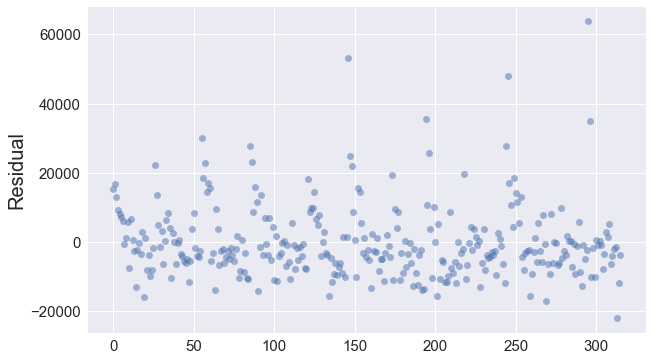

In [517]:
model = train_model('ridge', X, y);
evaluate_model(X, y)

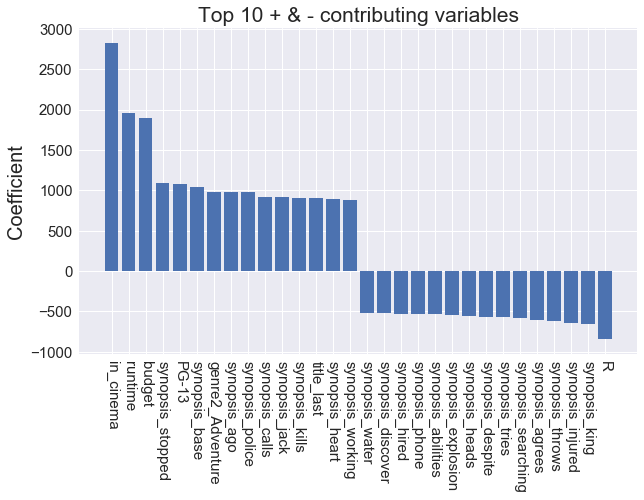

In [518]:
plot_most_relevant_features(model, column_names)

\+ coeff: stopped > base > ago > police

\- coeff: king < injured < throws < agrees

### Model C.2: Lasso

In [400]:
model = train_model('lasso', X_train, y_train);

R**2 : 0.6260581979141127
RMSE : 16165.478645713045


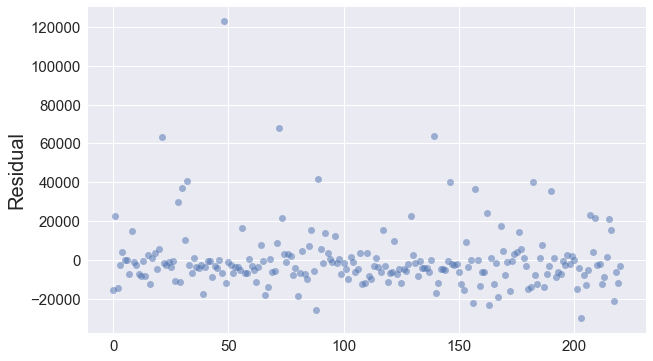

In [401]:
evaluate_model(X_train, y_train)

R**2 : 0.39532197341211905
RMSE : 22537.023037835355


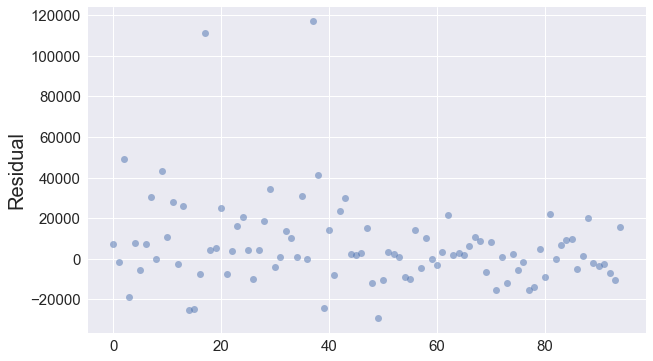

In [402]:
evaluate_model(X_test, y_test)

R**2 : 0.5835697867586116
RMSE : 17668.079440991583


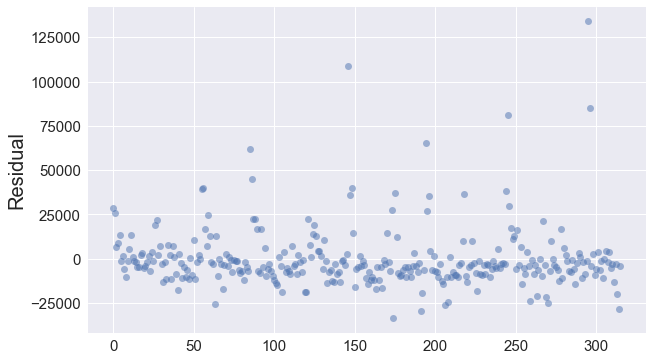

In [403]:
model = train_model('lasso', X, y);
evaluate_model(X, y)

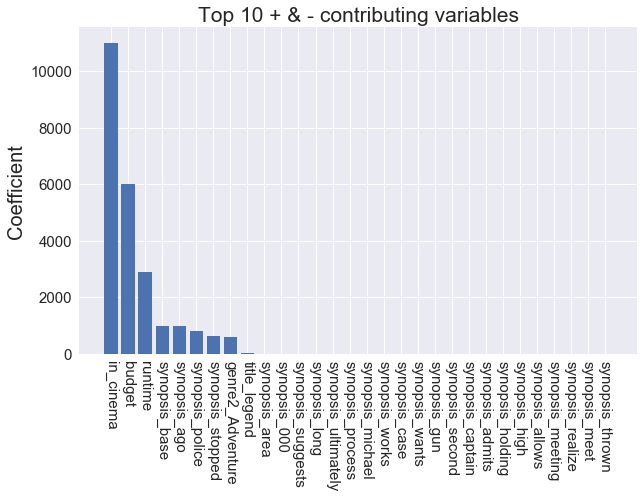

In [404]:
plot_most_relevant_features(model, column_names)

\+ coeff: base > ago > police > stopped

## Models D: All genres and features included

Here we include word2vec features. Let's see if adding these will help the model.

In [519]:
X_train, X_test, y_train, y_test, _ = split_dataset_for_genre(pc, w2v=True)
X, _, y, _, column_names = split_dataset_for_genre(pc, w2v=True, whole=True)

### Model D.1: Ridge

In [520]:
model = train_model('ridge', X_train, y_train);

R**2 : 0.9670695360719113
RMSE : 3233.387363276305


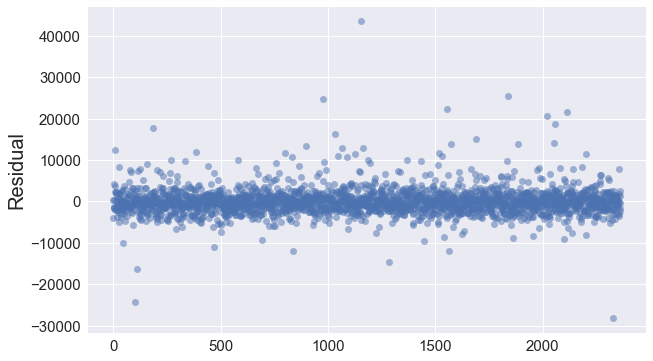

In [521]:
evaluate_model(X_train, y_train)

R**2 : -0.10766903364981228
RMSE : 17368.252789275426


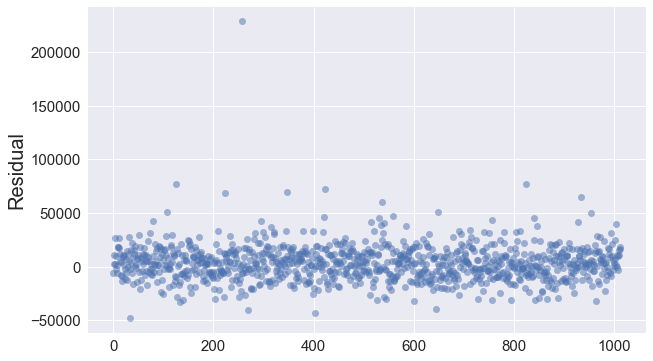

In [522]:
evaluate_model(X_test, y_test)

R**2 : 0.9677318014663574
RMSE : 3131.7100936918414


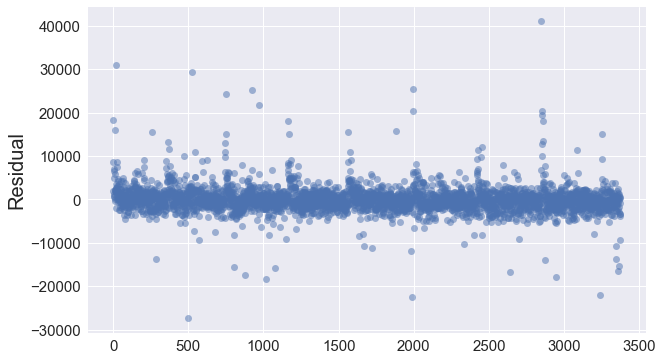

In [523]:
model = train_model('ridge', X, y);
evaluate_model(X, y)

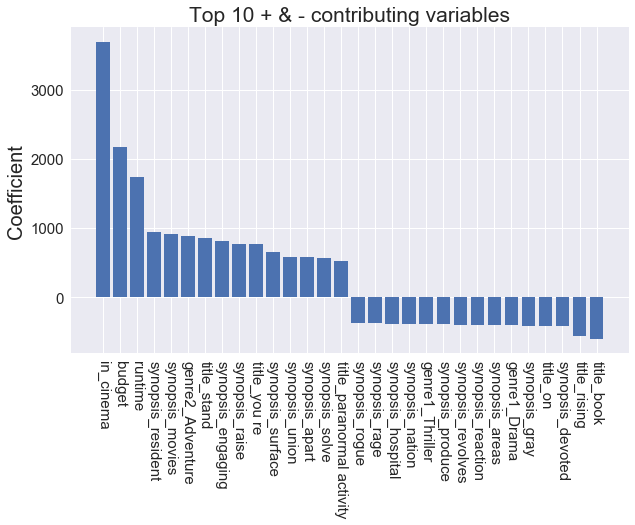

In [524]:
plot_most_relevant_features(model, column_names)

### Model D.2: Lasso

In [411]:
model = train_model('lasso', X_train, y_train);

R**2 : 0.47725647177802333
RMSE : 12882.588792443827


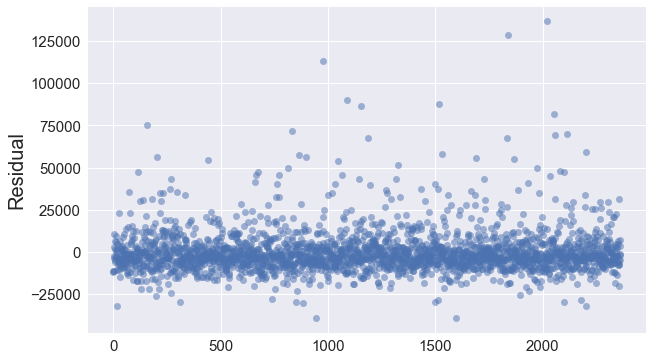

In [412]:
evaluate_model(X_train, y_train)

R**2 : 0.24650734632785898
RMSE : 14324.868220148184


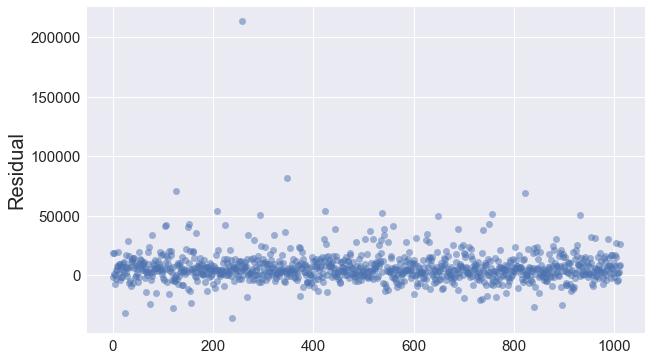

In [413]:
evaluate_model(X_test, y_test)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R**2 : 0.482044993240923
RMSE : 12547.009003868407


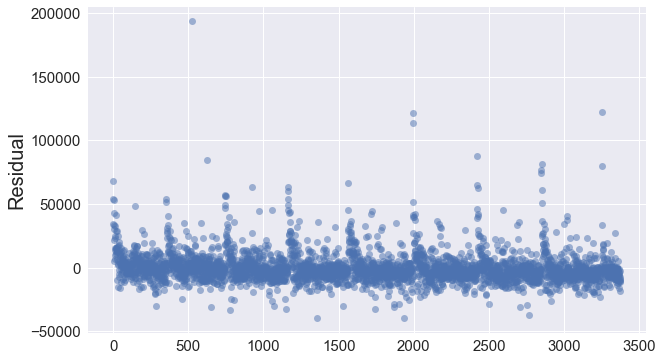

In [414]:
model = train_model('lasso', X, y);
evaluate_model(X, y)

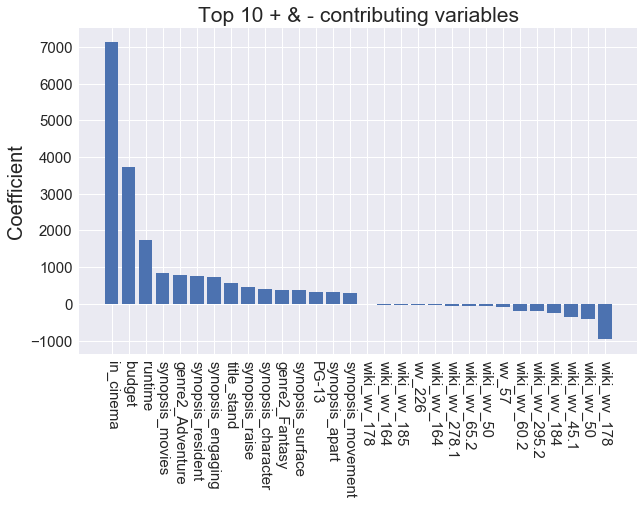

In [415]:
plot_most_relevant_features(model, column_names)

## Models E: Documentary, all features included

In [416]:
X_train, X_test, y_train, y_test, _ = split_dataset_for_genre(pc, 'Drama', w2v=True)
X, _, y, _, column_names = split_dataset_for_genre(pc, 'Drama', w2v=True, whole=True)

### Model E.1: Ridge

In [417]:
model = train_model('ridge', X_train, y_train);

R**2 : 0.9882716195041769
RMSE : 1297.1703020174648


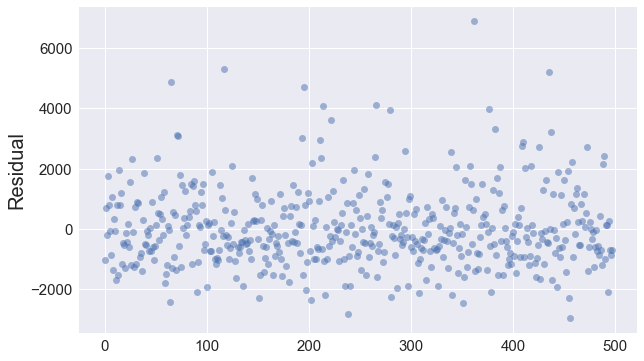

In [418]:
evaluate_model(X_train, y_train)

R**2 : -0.2905743185505789
RMSE : 12035.949838213854


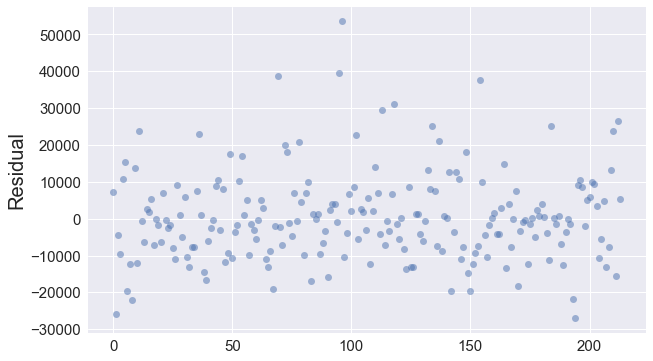

In [419]:
evaluate_model(X_test, y_test)

R**2 : 0.9981200035263633
RMSE : 502.232474169493


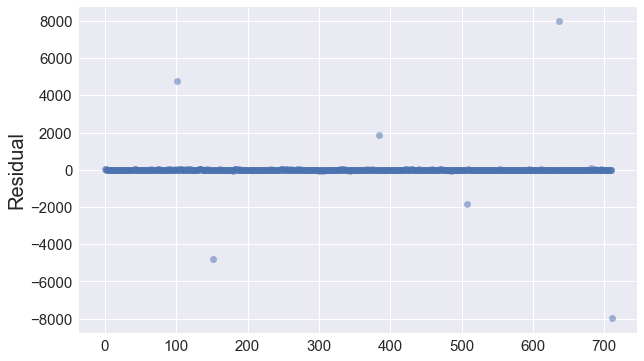

In [420]:
model = train_model('ridge', X, y);
evaluate_model(X, y)

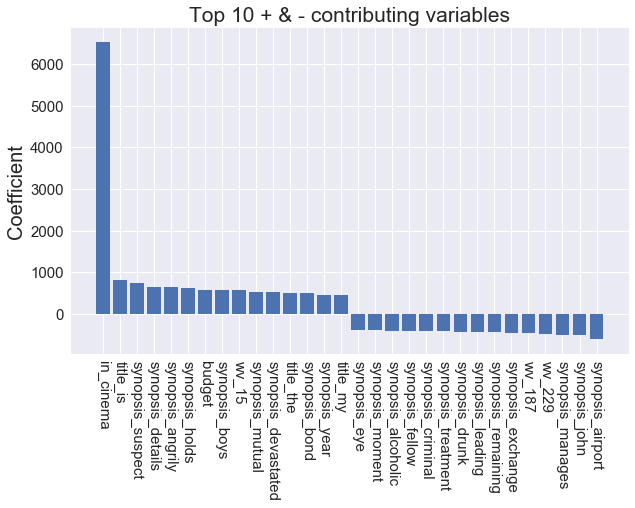

In [421]:
plot_most_relevant_features(model, column_names)

### Model E.2: Lasso

In [422]:
model = train_model('lasso', X_train, y_train);

R**2 : 0.4339692279551157
RMSE : 9011.518833883998


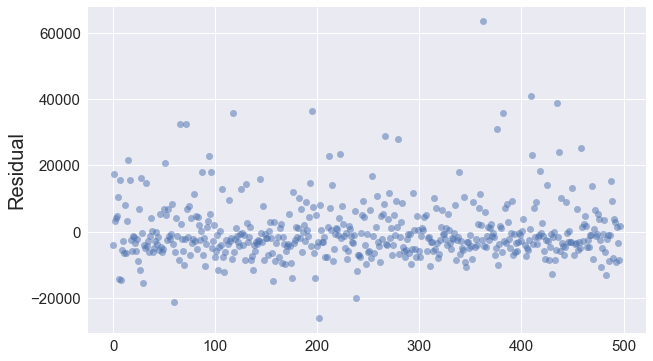

In [423]:
evaluate_model(X_train, y_train)

R**2 : 0.3570000017363485
RMSE : 8495.60566011481


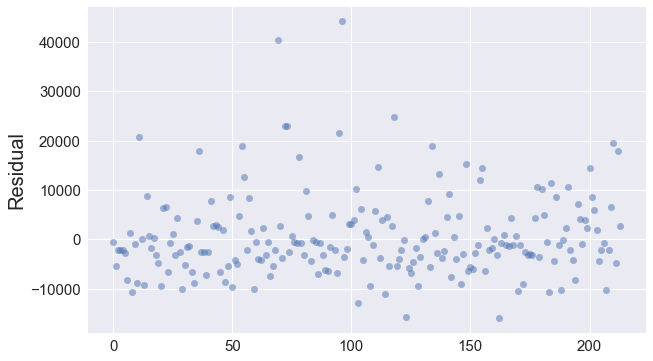

In [424]:
evaluate_model(X_test, y_test)

R**2 : 0.48129219876981
RMSE : 8342.335720047973


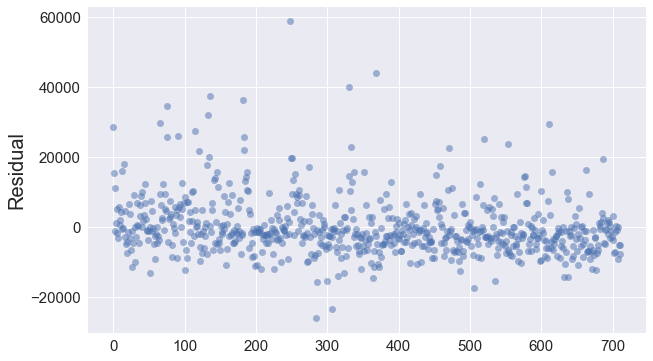

In [425]:
model = train_model('lasso', X, y);
evaluate_model(X, y)

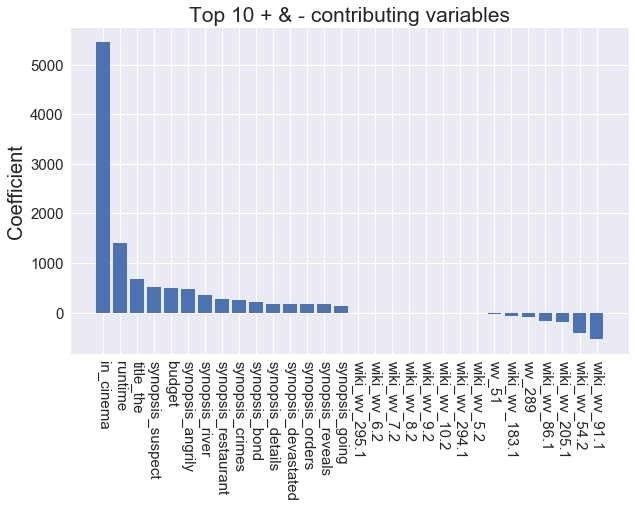

In [426]:
plot_most_relevant_features(model, column_names)

## Model F: Action, all features included

In [427]:
X_train, X_test, y_train, y_test, _ = split_dataset_for_genre(pc, 'Action', w2v=True)
X, _, y, _, column_names = split_dataset_for_genre(pc, 'Action', w2v=True, whole=True)

### Model F.1: Ridge

In [428]:
model = train_model('ridge', X_train, y_train);

R**2 : 0.9911868428165825
RMSE : 2481.7173552293725


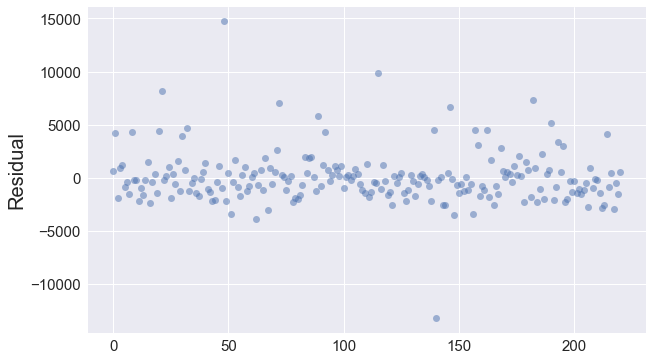

In [429]:
evaluate_model(X_train, y_train)

R**2 : 0.1502166912160544
RMSE : 26717.053085615302


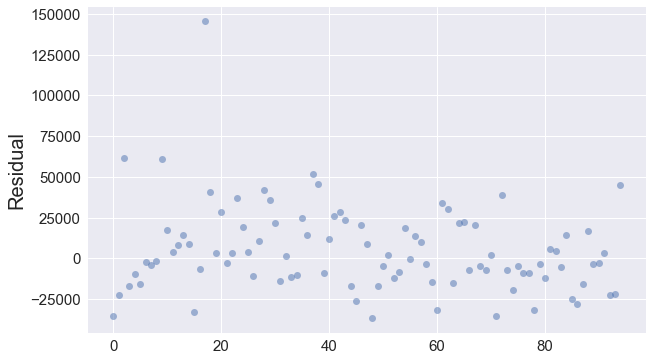

In [430]:
evaluate_model(X_test, y_test)

R**2 : 0.9929162737483366
RMSE : 2304.3535506762173


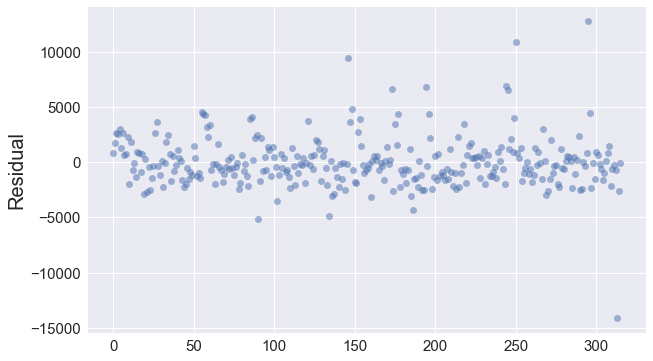

In [431]:
model = train_model('ridge', X, y);
evaluate_model(X, y)

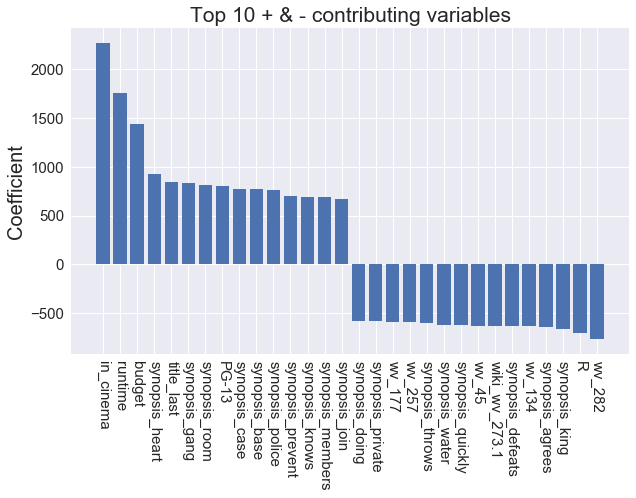

In [432]:
plot_most_relevant_features(model, column_names)

### Model F.2: Lasso

In [433]:
model = train_model('lasso', X_train, y_train);

R**2 : 0.6344755398891
RMSE : 15982.502537517235


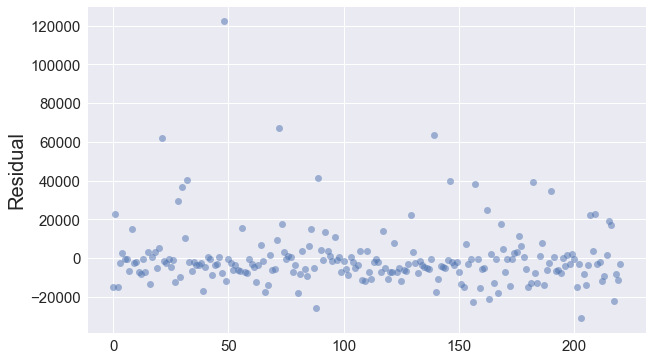

In [434]:
evaluate_model(X_train, y_train)

R**2 : 0.395296262079623
RMSE : 22537.50217773107


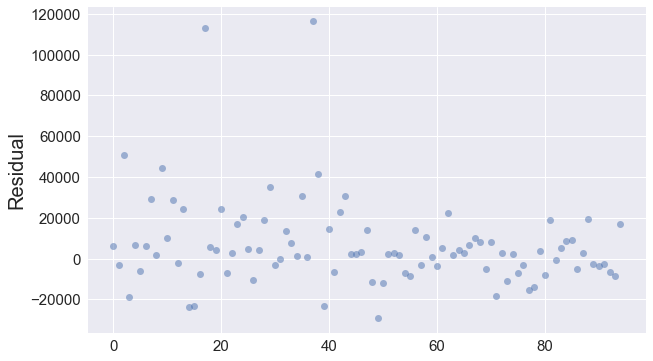

In [435]:
evaluate_model(X_test, y_test)

R**2 : 0.586181703267215
RMSE : 17612.58378300173


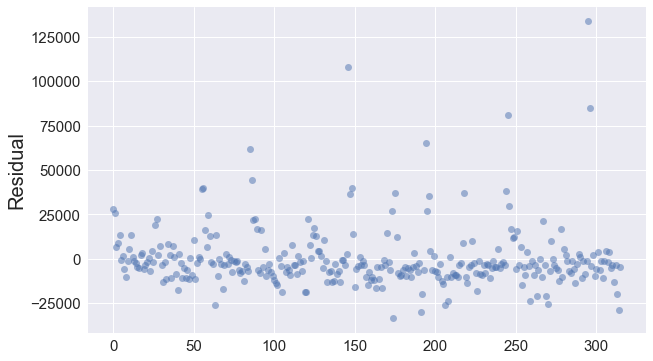

In [436]:
model = train_model('lasso', X, y);
evaluate_model(X, y)

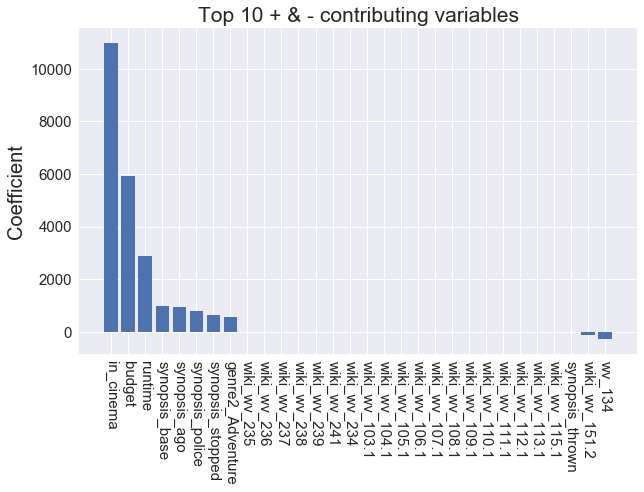

In [437]:
plot_most_relevant_features(model, column_names)

## Conclusion

The words in the title and synopses capture some of the variance of the box office performance. However, from the preliminary analysis, it seems that text alone is not enough to predict box office values (in terms of total gross per cinema) with high certainty. 

Based on our model without word2vec features, synopses with "movies", "engaging", "resident" and titles with "stand" contribute to success, while synopses with "deaf", "jin", "talks", "rents" contribute to failure. I noticed that most ridge models were prone to overfitting (high train R^2, low test R^2), so regularization is very important with such a high-dimensional feature set.

It is also worth mentioning that the model for Action has relatively high R^2 on train and test though RMSE is high. 

This preliminary study shows promise that the textual content has some information content that predicts box office performance.

There are many other factors to success. Some other factors worth considering are:
* the actors and actresses involved (though this might be tied to the budget, but budget is mostly NaN in the dataset)
* more temporal features (month, holiday, etc)
* more details about the movie (reviews of the movie; also, is the movie based on a book? is the movie tied to a famous event or person?)

Another recommendation is to treat the problem as a classification problem. It seems to be an easier problem to predict success or not success, but it would be quite subjective to define what success is. One idea I have is to define a movie as successful if it is profitable: if its revenue exceeds its budget.

Also, more meticulous hyperparameter selection is recommended (ex. n in n-grams, choosing tfidf hyperparameters, ridge/lasso alphas, etc.)